### Import data

In [177]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
!ls -a /content/drive/MyDrive/finpros

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
FPT.csv  MSN.csv  PNJ.csv  VIC.csv


In [178]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Readme**

To run this .ipynb file, can use Google colab. Upload 4 datasets to Google Drive in 'MyDrive' in 'finpros' folder

If run on other platform, you can change the file path

In [179]:
fpt_data = pd.read_csv("/content/drive/MyDrive/finpros/FPT.csv")
msn_data = pd.read_csv("/content/drive/MyDrive/finpros/MSN.csv")
pnj_data = pd.read_csv("/content/drive/MyDrive/finpros/PNJ.csv")
vic_data = pd.read_csv("/content/drive/MyDrive/finpros/VIC.csv")

In [180]:
for data in [fpt_data, msn_data, pnj_data, vic_data]:
  print(data.shape)

(97406, 8)
(135354, 8)
(125309, 8)
(101266, 8)


### Workflow

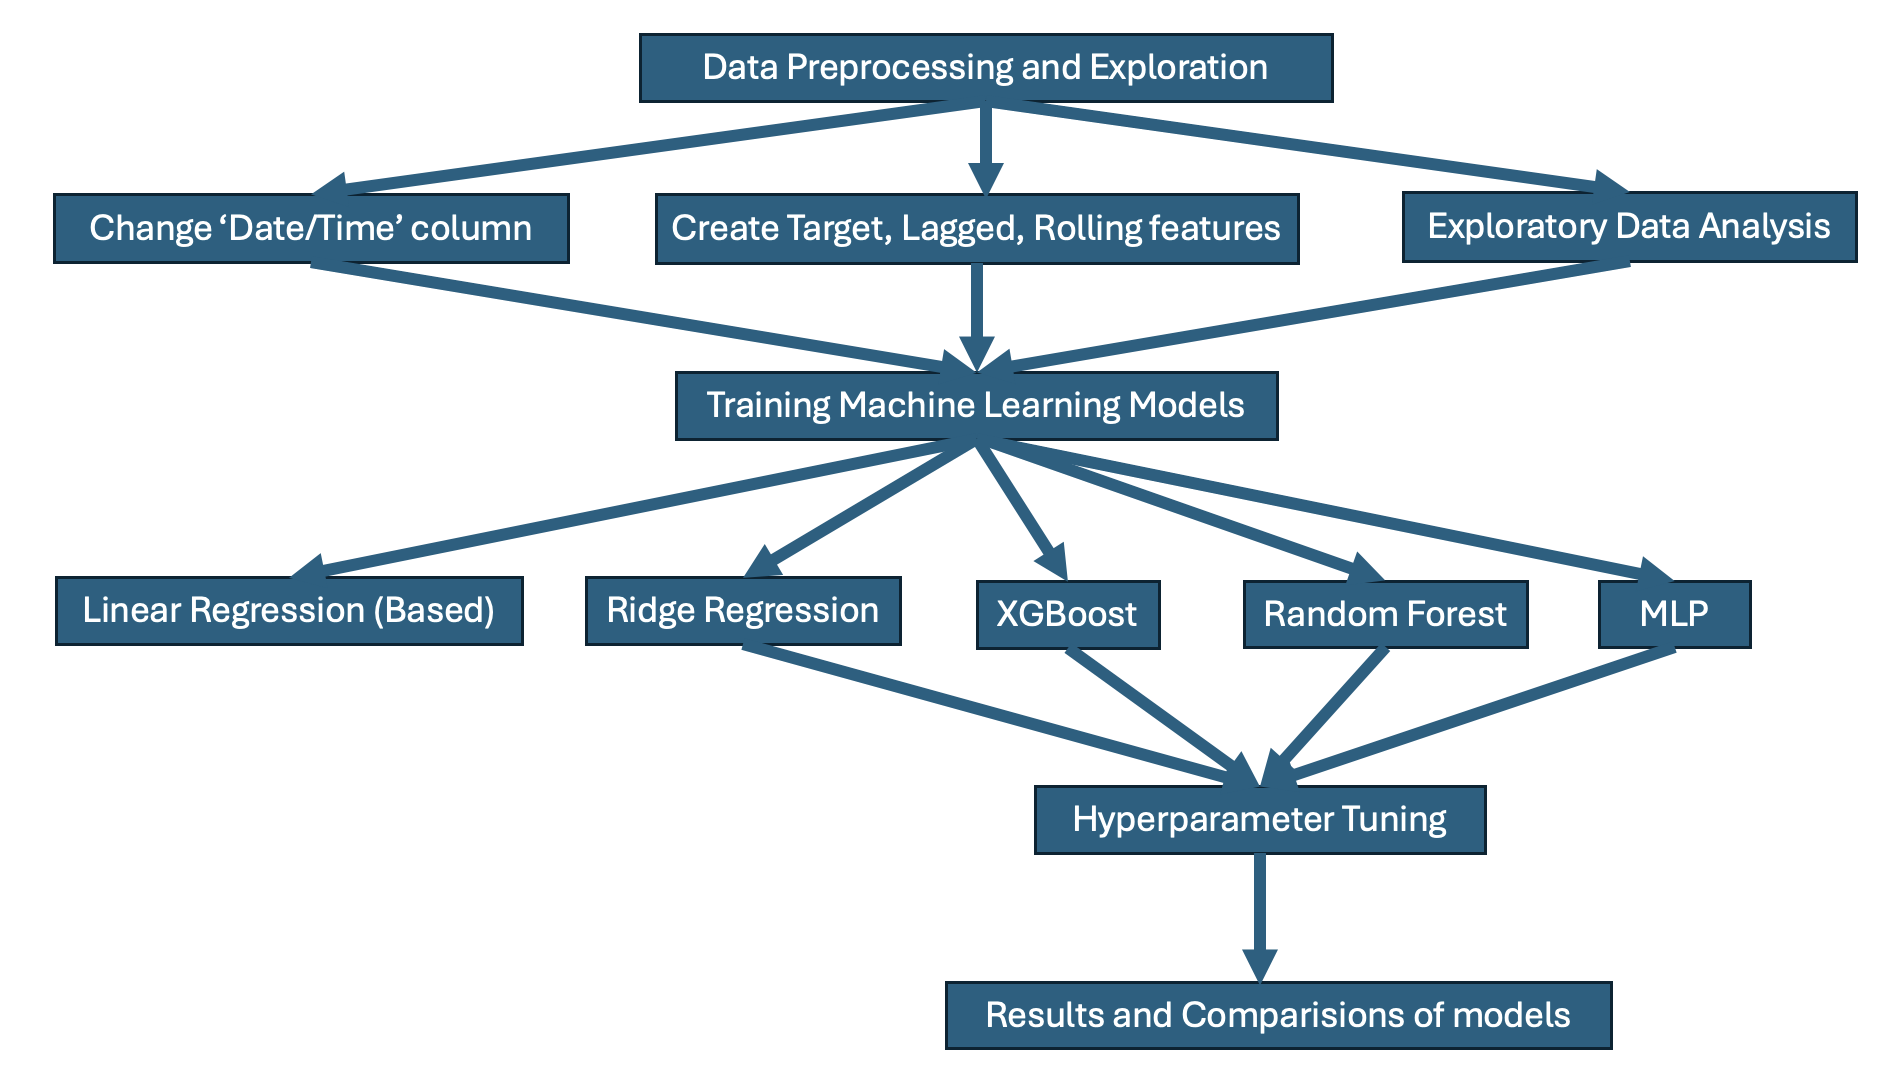

# **Data Exploration and Preprocessing**

In [159]:
import pandas as pd
import math
from sklearn.feature_selection import f_regression, mutual_info_regression

## Check for NA values and duplicate rows in each dataset and print if they exist

- Dataset: FPT - No NA values or duplicate rows
- Dataset: MSN - No NA values or duplicate rows
- Dataset: PNJ - No NA values or duplicate rows
- Dataset: VIC - No NA values or duplicate rows


In [138]:
for name, data in zip(["FPT", "MSN", "PNJ", "VIC"], [fpt_data, msn_data, pnj_data, vic_data]):
    na_count = data.isna().sum().sum()
    duplicate_count = data.duplicated().sum()
    if na_count > 0 or duplicate_count > 0:
        print(f"Dataset: {name}")
        if na_count > 0:
            print(f"  - NA values: {na_count}")
        if duplicate_count > 0:
            print(f"  - Duplicate rows: {duplicate_count}")
    else:
        print(f"Dataset: {name} - No NA values or duplicate rows")

Dataset: FPT - No NA values or duplicate rows
Dataset: MSN - No NA values or duplicate rows
Dataset: PNJ - No NA values or duplicate rows
Dataset: VIC - No NA values or duplicate rows


## 'Date/Time' column

#### **Change column format**

'Date/Time' to 'Month', 'Day', 'Year' and 'Hour', 'Minute

In [181]:
for data in [fpt_data, msn_data, pnj_data, vic_data]:
  # Split 'Date/Time' column to 'Date' and 'Time' columns
  data['Date/Time'] = data['Date/Time'].astype(str)
  data[['Date', 'Time']] = data['Date/Time'].str.split(' ', expand=True)

  # Split 'Date' column to 'Month', 'Day', 'Year' columns
  data[['Month', 'Day', 'Year']] = data['Date'].str.split('/', expand=True)

  #Split 'Time' column to 'Hour', 'Minute' column
  data[['Hour', 'Minute']] = data['Time'].str.split(':', expand=True)

#### **Plot time distribution**

Four stocks follow the same time distribution
- Time starts from 9:15am to 14:30pm.
- Do not have data at the 12pm range
- Have little value count at 11:30am and after 14:29pm
- Have high value count at after 11:30am and after the little value count at 14:29pm time range

However, the value count in each stock time distribution is different (PNJ's and MSN's value counts are more than 500, while that for FPT and VIC are more than 400 less than 500)

<ipython-input-182-a1b8264b9742>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Time', data=data, order=time_order, palette="viridis", ax=ax)
<ipython-input-182-a1b8264b9742>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Time', data=data, order=time_order, palette="viridis", ax=ax)
<ipython-input-182-a1b8264b9742>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Time', data=data, order=time_order, palette="viridis", ax=ax)
<ipython-input-182-a1b8264b9742>:6: FutureWarning: 

Passing `palette` without assigning `hue` is de

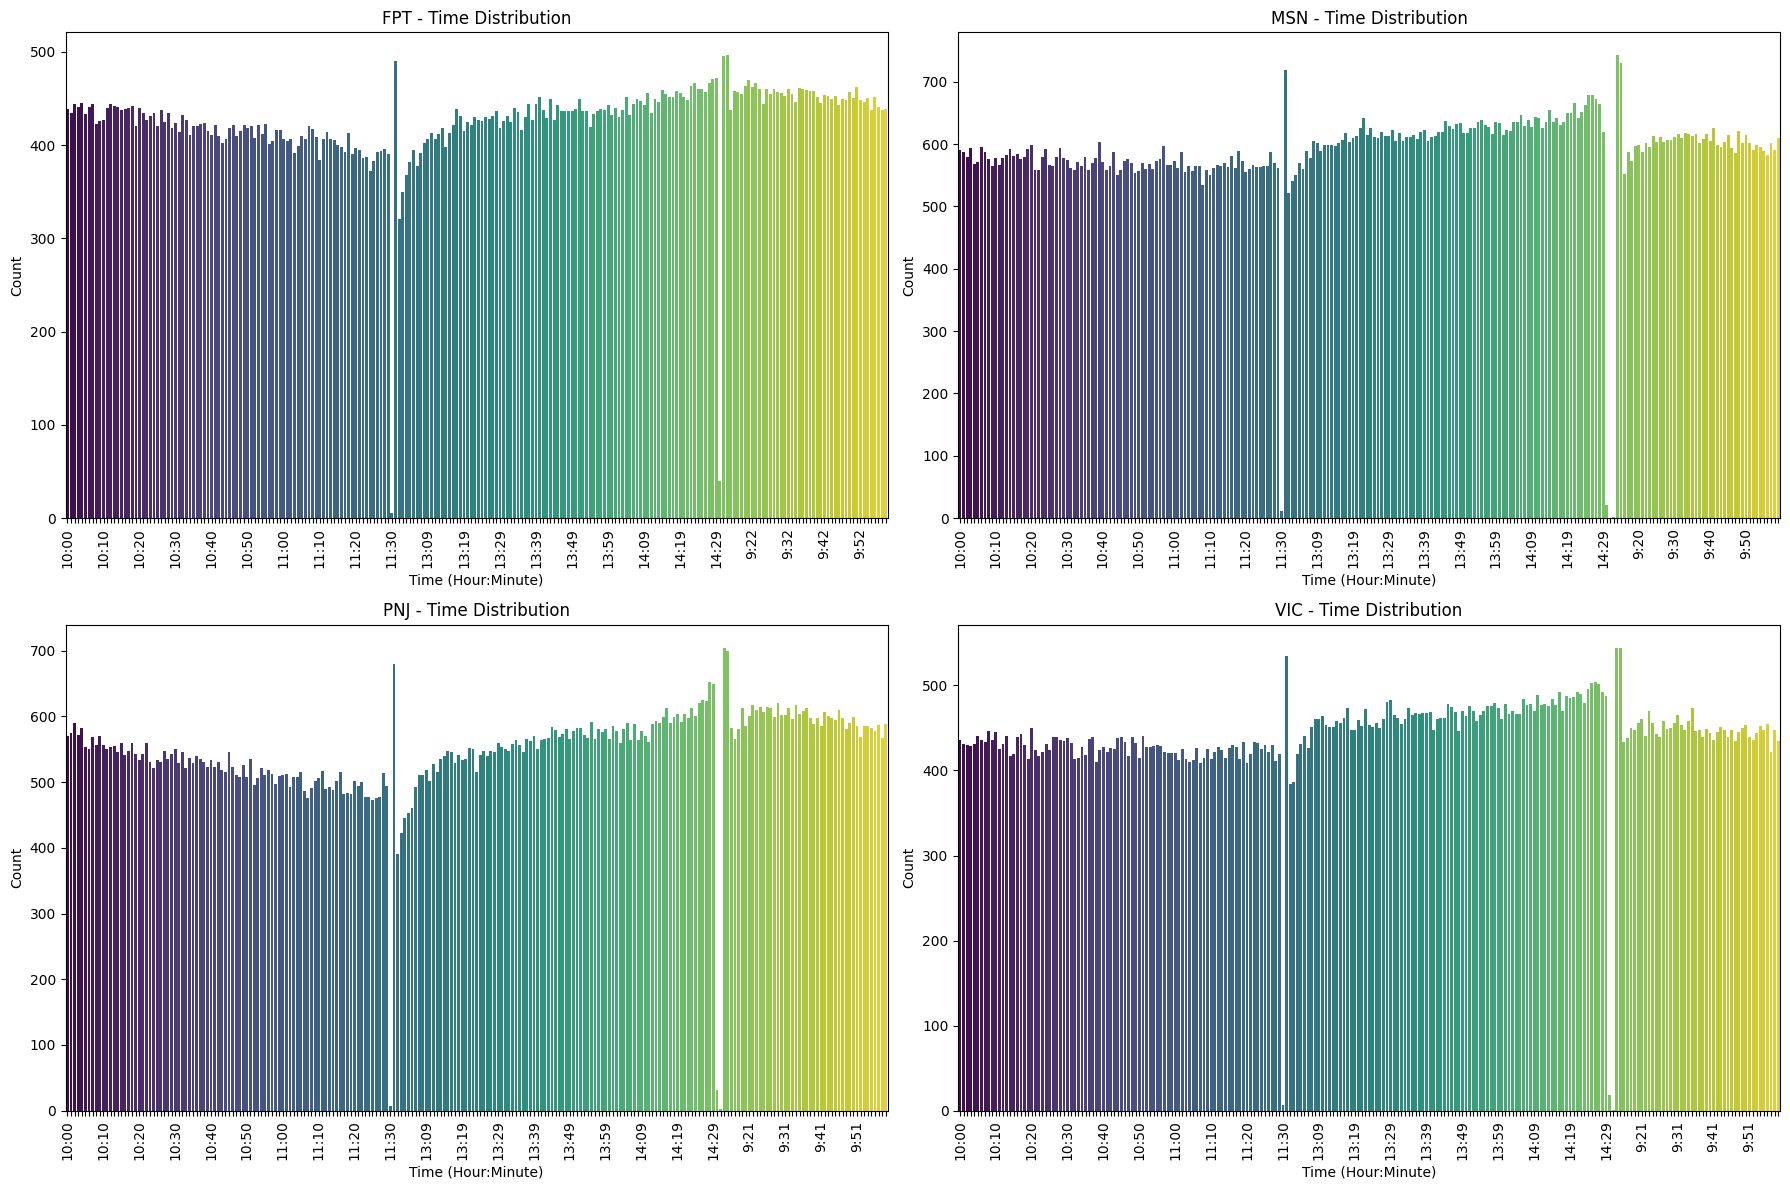

In [182]:
def plot_time_distribution_all(datasets, names, skip=10):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    for ax, data, name in zip(axes.flatten(), datasets, names):
        time_order = sorted(data['Time'].unique())
        sns.countplot(x='Time', data=data, order=time_order, palette="viridis", ax=ax)
        ax.set_title(f"{name} - Time Distribution")
        ax.set_xlabel("Time (Hour:Minute)")
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=90)
        for i, label in enumerate(ax.xaxis.get_ticklabels()):
            if i % skip != 0:
                label.set_visible(False)
    plt.tight_layout()
    plt.show()
datasets = [fpt_data, msn_data, pnj_data, vic_data]
names = ["FPT", "MSN", "PNJ", "VIC"]

plot_time_distribution_all(datasets, names, skip=10)

#### **Create 'Day_Difference', 'Hour_Difference', 'Minute_Difference' columns**

- 'Day Difference' column: how many days different from the first day in the data
- Hour Difference' column: how many hours different from the first hour of that day
- 'Minute Difference' column: how many minutes difference from the first minute of the first day

In [162]:
def time_difference(datasets):
    for data in datasets:
        for col in ['Year', 'Month', 'Day', 'Hour', 'Minute']:
            if data[col].dtype == 'object':
                data[col] = pd.to_numeric(data[col], errors='coerce')
        data['DateTime'] = pd.to_datetime({
            'year': data['Year'],
            'month': data['Month'],
            'day': data['Day'],
            'hour': data['Hour'],
            'minute': data['Minute']
        })
        data['Date_Only'] = data['DateTime'].dt.normalize()
    for data in datasets:
        # 'Day Difference'
        first_year = int(data['Year'].iloc[0])
        first_month = int(data['Month'].iloc[0])
        first_day = int(data['Day'].iloc[0])
        data['Day_Difference'] = (
            (data['Year'] - first_year) * 365 +
            (data['Month'] - first_month) * 30 +
            (data['Day'] - first_day)
        )

        # 'Hour Difference'
        data['Time_in_Minutes'] = data['Hour'] * 60 + data['Minute']
        data['Daily_Min'] = data.groupby('Date_Only')['Time_in_Minutes'].transform('min')
        data['Hour_Difference'] = ((data['Time_in_Minutes'] - data['Daily_Min']) // 60).astype(int)

        # 'Minute Difference'
        first_datetime = data['DateTime'].iloc[0]
        data['Minute_Difference'] = ((data['DateTime'] - first_datetime).dt.total_seconds() / 60.0).astype(int)

for data in [fpt_data, msn_data, pnj_data, vic_data]:
    data.sort_values(by=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
time_difference([fpt_data, msn_data, pnj_data, vic_data])

#### **Drop unneccasry columns**

- Drop 'Open Interest' because all 0 values
- Drop 'Date/Time', 'Date', 'Time', 'Month', 'Day', 'Year', 'Hour', 'Minute', 'Time_in_Minutes', 'Daily_Min', 'DateTime', 'Date_Only' because can be represented by 'Hour_Difference', 'Day_Difference', 'Minute_Difference'
- Drop 'Ticker' because only represents stock's name


In [163]:
for data in [fpt_data, msn_data, pnj_data, vic_data]:
  data = data.drop(columns=['Ticker', 'Date/Time', 'Date', 'Time', 'Month', 'Day', 'Year', 'Hour', 'Minute', 'Time_in_Minutes',
           'Daily_Min', 'DateTime', 'Date_Only', 'Open Interest'], inplace=True, errors='ignore')

#### **Plot Hour Difference Distribution**

Within a day, all four stocks have a similar hour difference distribution with 6 unique hour difference values

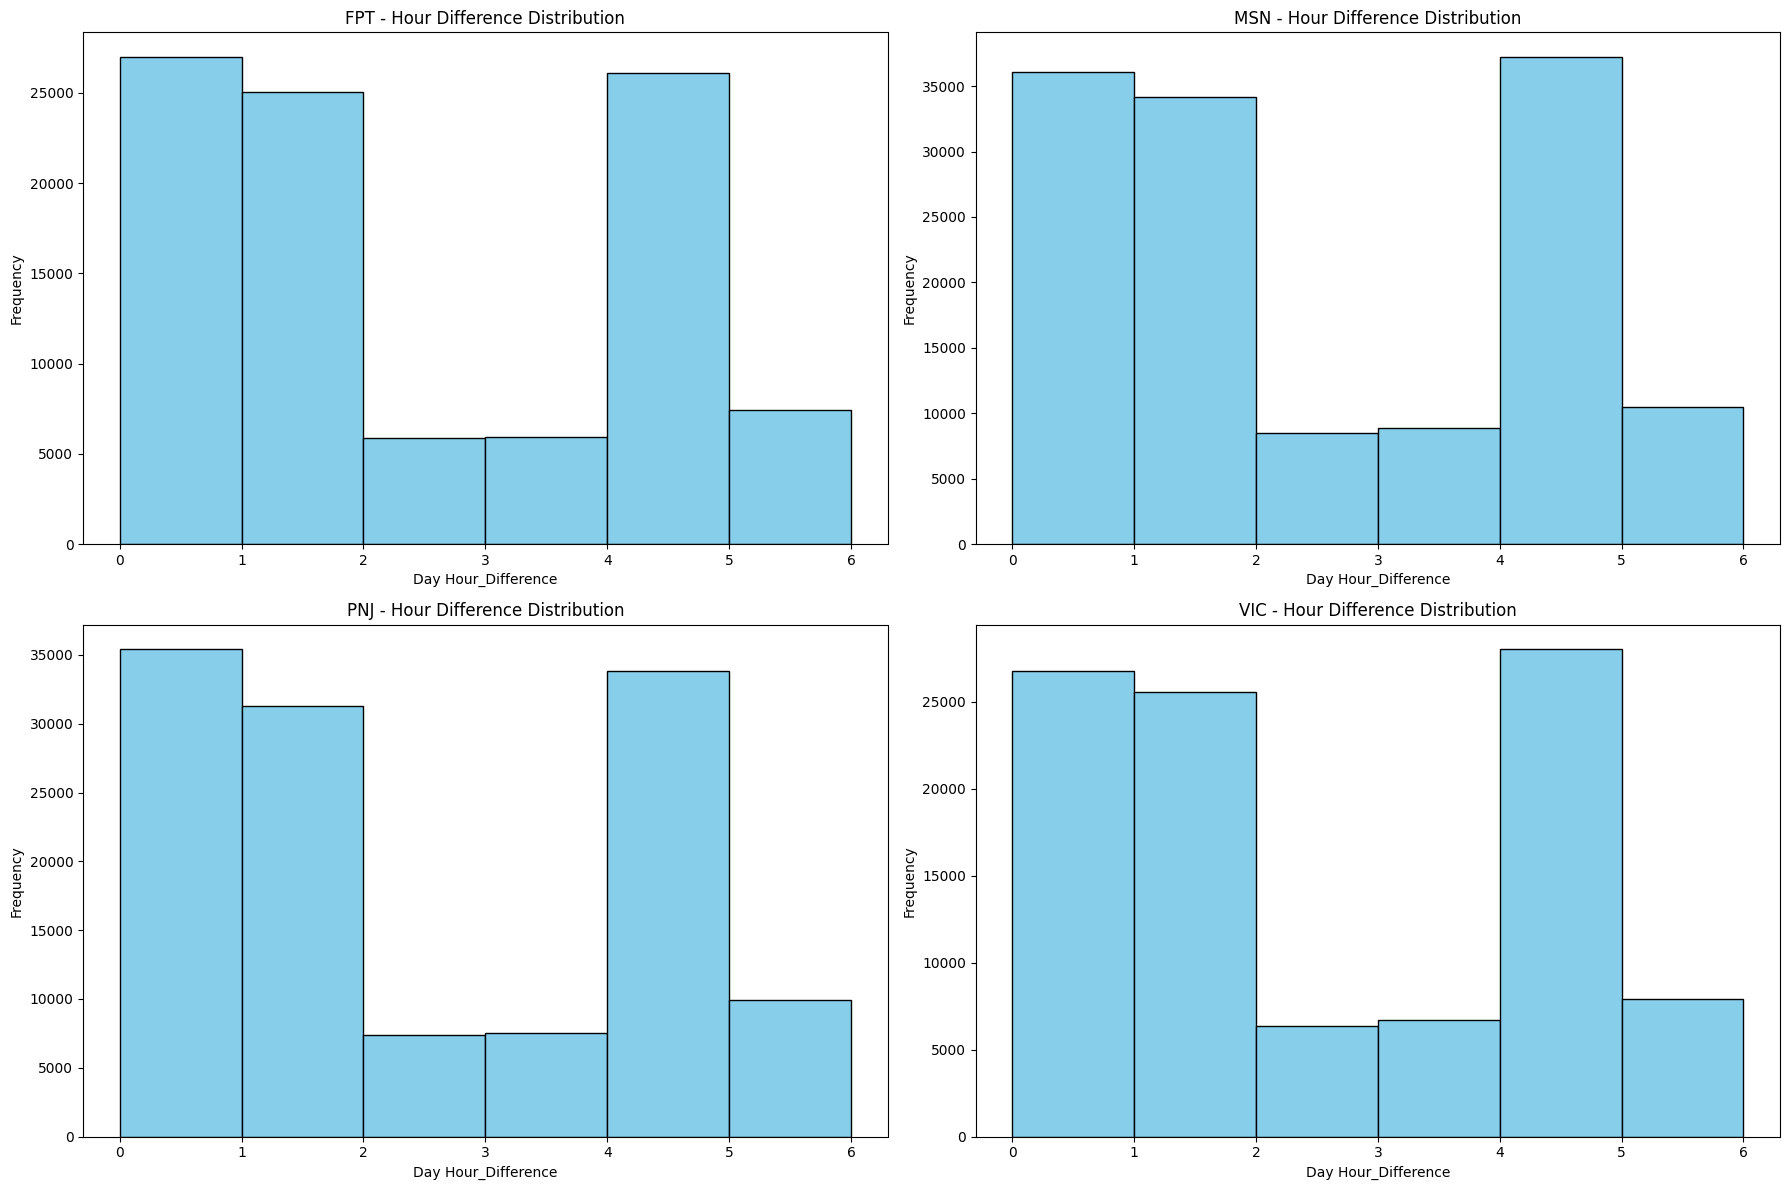

In [164]:
plt.figure(figsize=(18, 12))
for i, (data, name) in enumerate(zip([fpt_data, msn_data, pnj_data, vic_data], ["FPT", "MSN", "PNJ", "VIC"]), start=1):
    plt.subplot(2, 2, i)
    min_day = int(data['Hour_Difference'].min())
    max_day = int(data['Hour_Difference'].max())
    bins = range(min_day, max_day + 2)
    plt.hist(data['Hour_Difference'], bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"{name} - Hour Difference Distribution")
    plt.xlabel("Day Hour_Difference")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Create new columns Target, Close_lag, Volume_lag, Rolling Average

1) Target
- The target is the price change: next Close minus current Close.

2) Lagged Features
- Use previous values (e.g., Close_lag1, Close_lag2, Volume_lag1, Volume_lag2) as inputs.
- They capture recent trends and momentum.

3) Rolling Averages
- Compute averages over a fixed window (e.g., Close_MA_5, Volume_MA_5).
- They smooth out noise and reveal longer-term trends.

In [165]:
def data_engineering(df):
  df['Target'] = df['Close'].shift(-1) - df['Close']
  df = df.dropna().reset_index(drop=True)
  for lag in [1, 2, 3]:
      df[f'Close_lag{lag}'] = df['Close'].shift(lag)
      df[f'Volume_lag{lag}'] = df['Volume'].shift(lag)
  df['Close_MA_5'] = df['Close'].rolling(window=5).mean()
  df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
  df = df.dropna().reset_index(drop=True)
  return df
# Apply on datasets
fpt_data = data_engineering(fpt_data)
msn_data = data_engineering(msn_data)
pnj_data = data_engineering(pnj_data)
vic_data = data_engineering(vic_data)

## Exploratory Data Analysis

#### **Plot the trend of closing price based on 'Minute Difference' and 'Day Difference'**

'Minute Difference' and 'Day Difference' are both calculated based on the first minute/first day; therefore, the stock price trend is the same for two columns

MSN's and PNJ's closing price have some similarities in their trends
- Both increase in 100 first days then decrease in the next 100 days.
- After that, both stocks fluctuated before a decrease trend at around 800 days difference
- In last period, both stocks increased their price

FPT and VIC stocks have their own closing price trend, and have shorter period (less than 800 days) compared to MSN's and PNJ's period

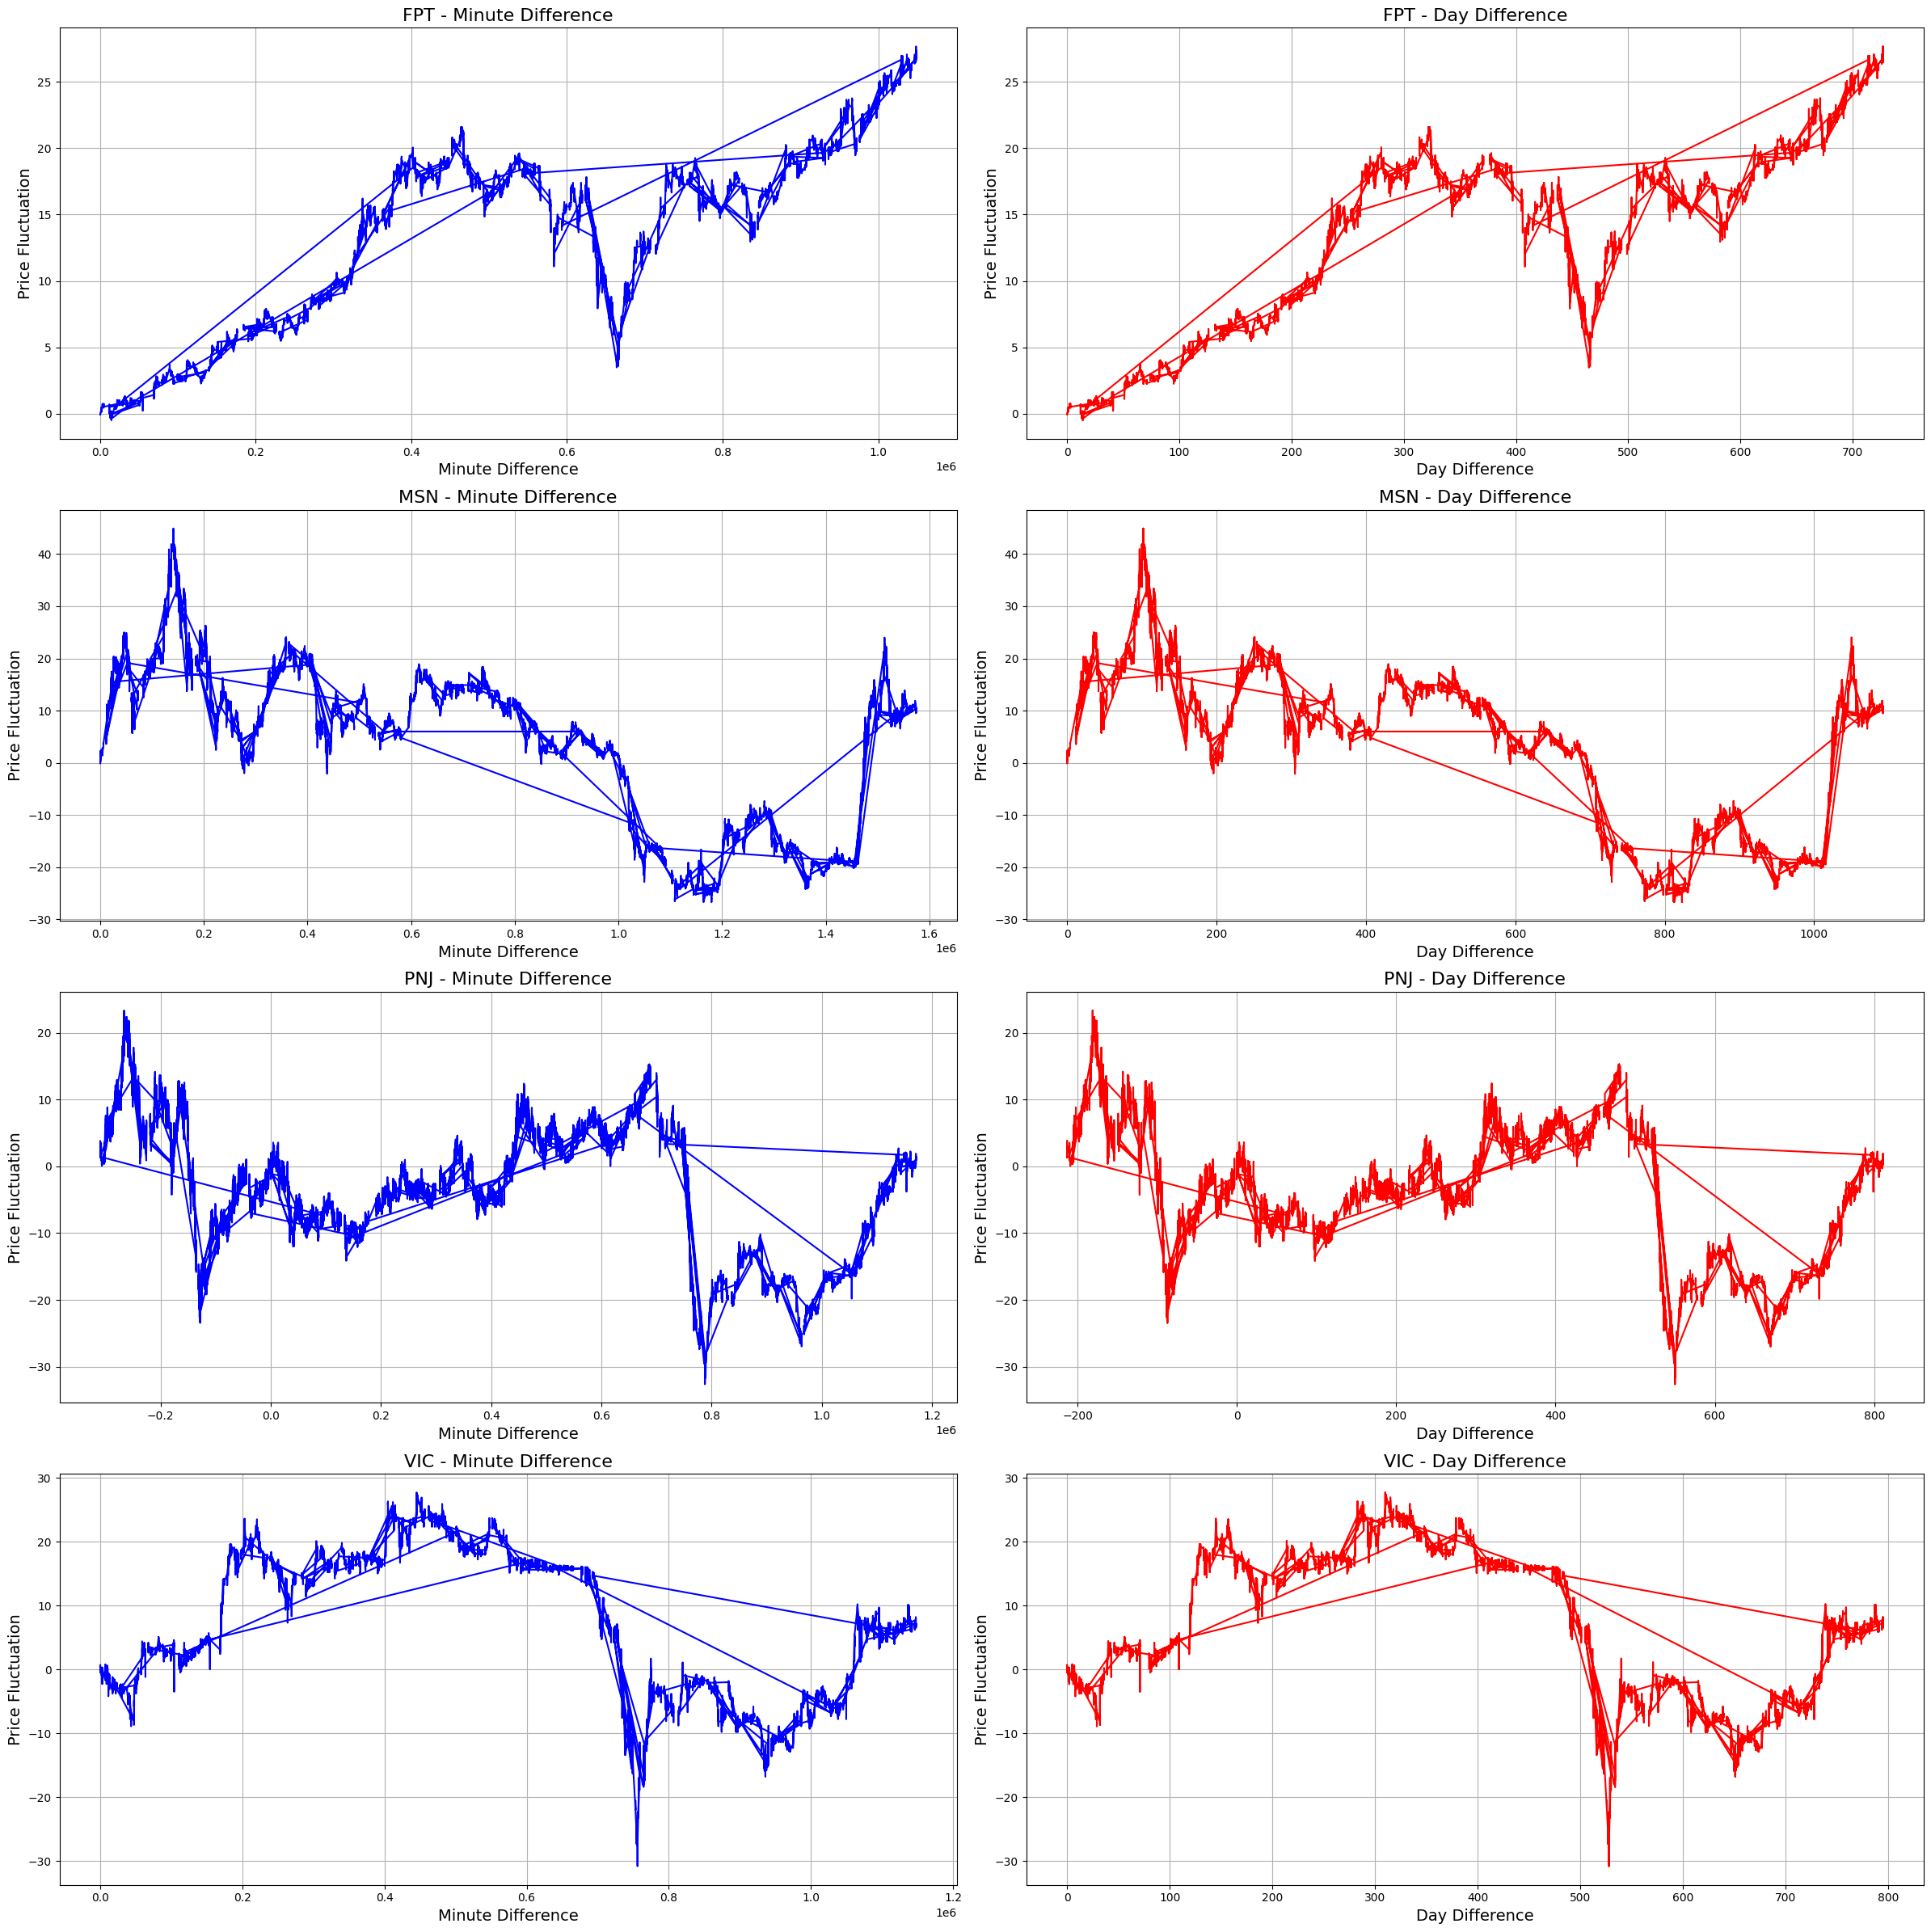

In [166]:
def plot_stock_fluctuation(datasets, names):
    n = len(datasets)
    fig, axes = plt.subplots(n, 2, figsize=(24, 6*n))
    if n == 1:
        axes = [axes]
    for i, (data, name) in enumerate(zip(datasets, names)):
        # Calculate price fluctuation: difference from the first price
        data['Price_Fluctuation'] = data['Close'] - data['Close'].iloc[0]
        # Plot by Minute_Difference
        ax = axes[i][0] if n > 1 else axes[0]
        ax.plot(data['Minute_Difference'], data['Price_Fluctuation'], color='blue')
        ax.set_title(f"{name} - Minute Difference", fontsize=16)
        ax.set_xlabel("Minute Difference", fontsize=14)
        ax.set_ylabel("Price Fluctuation", fontsize=14)
        ax.grid(True)
        # Plot by Day_Difference
        ax = axes[i][1] if n > 1 else axes[1]
        ax.plot(data['Day_Difference'], data['Price_Fluctuation'], color='red')
        ax.set_title(f"{name} - Day Difference", fontsize=16)
        ax.set_xlabel("Day Difference", fontsize=14)
        ax.set_ylabel("Price Fluctuation", fontsize=14)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# Apply on datasets
plot_stock_fluctuation([fpt_data, msn_data, pnj_data, vic_data], ["FPT", "MSN", "PNJ", "VIC"])

#### **Plot the trend of closing price within a day based on 'Hour Difference'**

1) Median Fluctuation Near Zero
- Across all four stocks, the median line in each boxplot is close to 0 at every hour.

  => On most days, the price at a given hour is roughly near the day’s open

2) A moderate to large range of intraday movements
- Outliers extend significantly above and below 0
  
  => On some days there are substantial intraday gains or losses.

3) No Strong Hourly Trend
- For each hour from 0 to 5, the median remains fairly flat.


4) Individual Stock Differences
- FPT has a tighter IQR than some of the others, though still with significant outliers.
- PNJ, MSN, and VIC each exhibit similarly broad distributions of intraday changes, with numerous large positive and negative outliers.

 => The differences among stocks mainly lie in the degree and frequency of extreme outliers, rather than in the median intraday trend.

<ipython-input-174-6174f984ebce>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Day_Difference', group_keys=False).apply(
<ipython-input-174-6174f984ebce>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Day_Difference', group_keys=False).apply(
<ipython-input-174-6174f984ebce>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior i

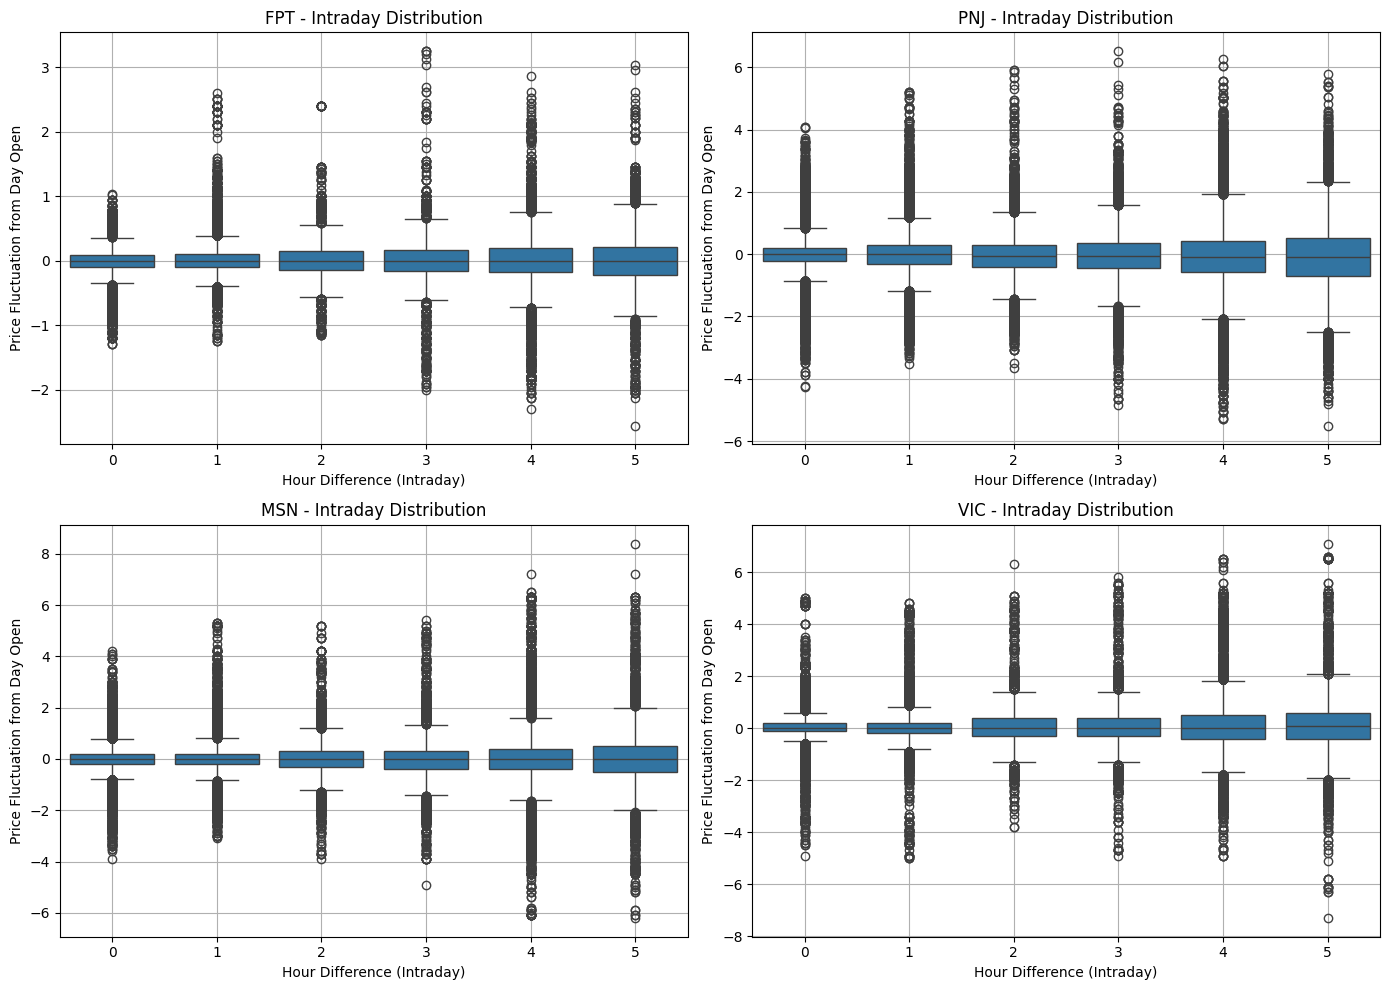

In [174]:
def prepare_fluctuation_data(df):
    df = df.copy()
    df.sort_values(['Day_Difference', 'Hour_Difference'], inplace=True)
    df = df.groupby('Day_Difference', group_keys=False).apply(
        lambda g: g.assign(Price_Fluctuation = g['Close'] - g['Close'].iloc[0]))
    return df
def plot_stock_box(ax, data, stock_name):
    sns.boxplot(x='Hour_Difference', y='Price_Fluctuation', data=data, ax=ax)
    ax.set_title(f"{stock_name} - Intraday Distribution")
    ax.set_xlabel("Hour Difference (Intraday)")
    ax.set_ylabel("Price Fluctuation from Day Open")
    ax.grid(True)
def boxplot_hour_difference(fpt_data, pnj_data, msn_data, vic_data):
    stocks = {
        "FPT": fpt_data,
        "PNJ": pnj_data,
        "MSN": msn_data,
        "VIC": vic_data}
    prepared = {name: prepare_fluctuation_data(df) for name, df in stocks.items()}
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for ax, (stock_name, data) in zip(axes.flatten(), prepared.items()):
        plot_stock_box(ax, data, stock_name)

    plt.tight_layout()
    plt.show()

boxplot_hour_difference(fpt_data, pnj_data, msn_data, vic_data)

#### **Plot volume trend**

- FPT: Usually **moderate trading**, but sometimes sees big jumps in volume.
- MSN: Has the **highest** **volume spikes**, meaning it experiences strong bursts of trading at specific times.
- PNJ: Generally **lower volume**, but occasionally has noticeable surges in trading.
- VIC: Fairly **steady overall**, with smaller, more frequent bumps in volume.

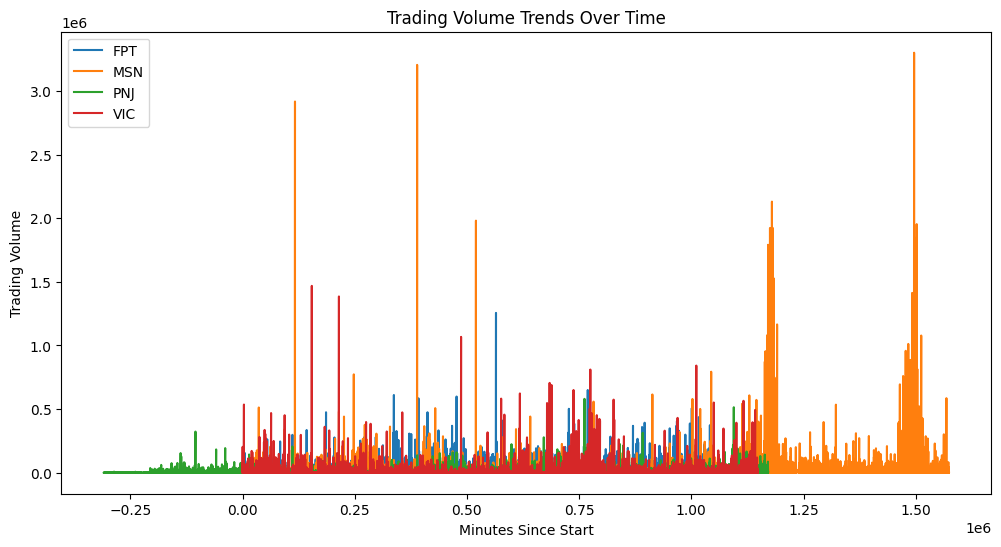

In [175]:
# Plot volume trends for all datasets
def plot_volume_trends(datasets, labels):
    plt.figure(figsize=(12,6))
    for data, label in zip(datasets, labels):
        plt.plot(data['Minute_Difference'], data['Volume'], label=label)
    plt.xlabel("Minutes Since Start")
    plt.ylabel("Trading Volume")
    plt.title("Trading Volume Trends Over Time")
    plt.legend()
    plt.show()

plot_volume_trends([fpt_data, msn_data, pnj_data, vic_data], ['FPT', 'MSN', 'PNJ', 'VIC'])

#### **Plot closing price percentage changes**

1) FPT, MSN, VIC
- Peak Around Zero: three stocks exhibit a large spike near 0% change, indicating that on most intervals, the price change is minimal. This suggests relatively small fluctuations around the previous close for the bulk of observations.
- Symmetrical Tails: indicating that gains and losses happen

2) PNJ
- Around 4% price swings
- Symmetrical distribution

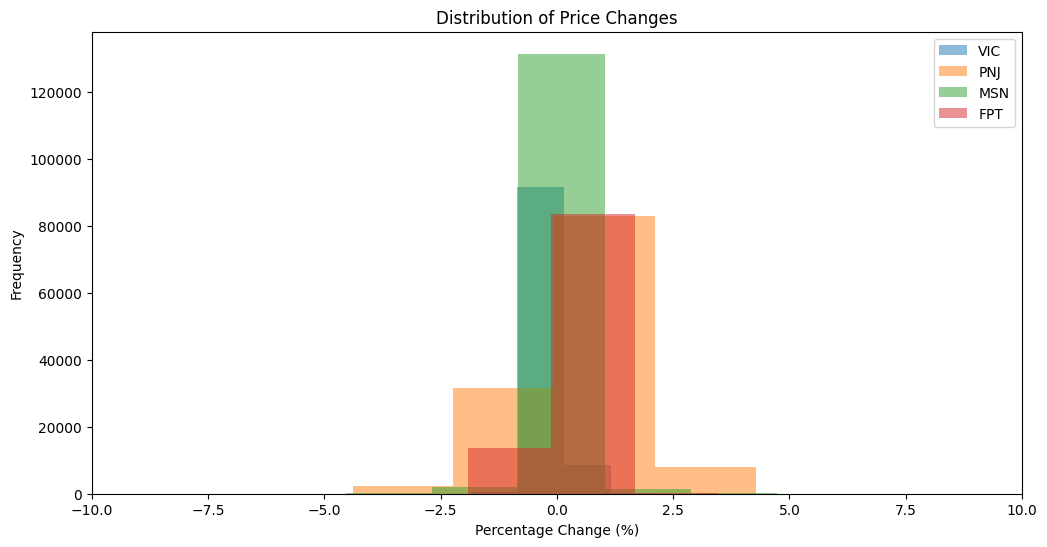

In [168]:
# Plot price fluctuations
def plot_price_fluctuations(datasets, labels, x_min=-10, x_max=10):
    plt.figure(figsize=(12,6))
    for data, label in zip(datasets, labels):
        pct_changes = data['Close'].pct_change().dropna() * 100
        plt.hist(pct_changes, bins=50, alpha=0.5, label=label)
    plt.xlim([x_min, x_max])
    plt.xlabel("Percentage Change (%)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Price Changes")
    plt.legend()
    plt.show()

plot_price_fluctuations([vic_data, pnj_data, msn_data, fpt_data], ['VIC', 'PNJ', 'MSN', 'FPT'], x_min=-10, x_max=10)

#### **Plot 'Target' column**

1) Histogram

- Shapes of distribution for FPT, MSN, VIC are centered around 0, a sharp peak, and no sustainable outliner
- Shape of distribution for PNJ is also centeres around 0, 3 peaks (2 small peaks and 1 sharp peak), no sustainable outliner
=> Relatively, 4 stocks have small day-to-day fluctuations most of the time
=> FPT and MSN see larger postive price swings, VIC sees larger negative price swings
=> PNJ see the price swings positively and negatively

2) Time Series

- FPT: mostly has minor day‐to‐day changes, with sporadic large moves
- MSN: experienced a period of large positive fluctuations in mid‐data range.
- PNJ: indicates occasional significant upward moves.
- VIC: Mostly is near zero with moderate swings, but occasionally exhibits bigger upward and downward fluctuations.




Plotting for FPT stock:


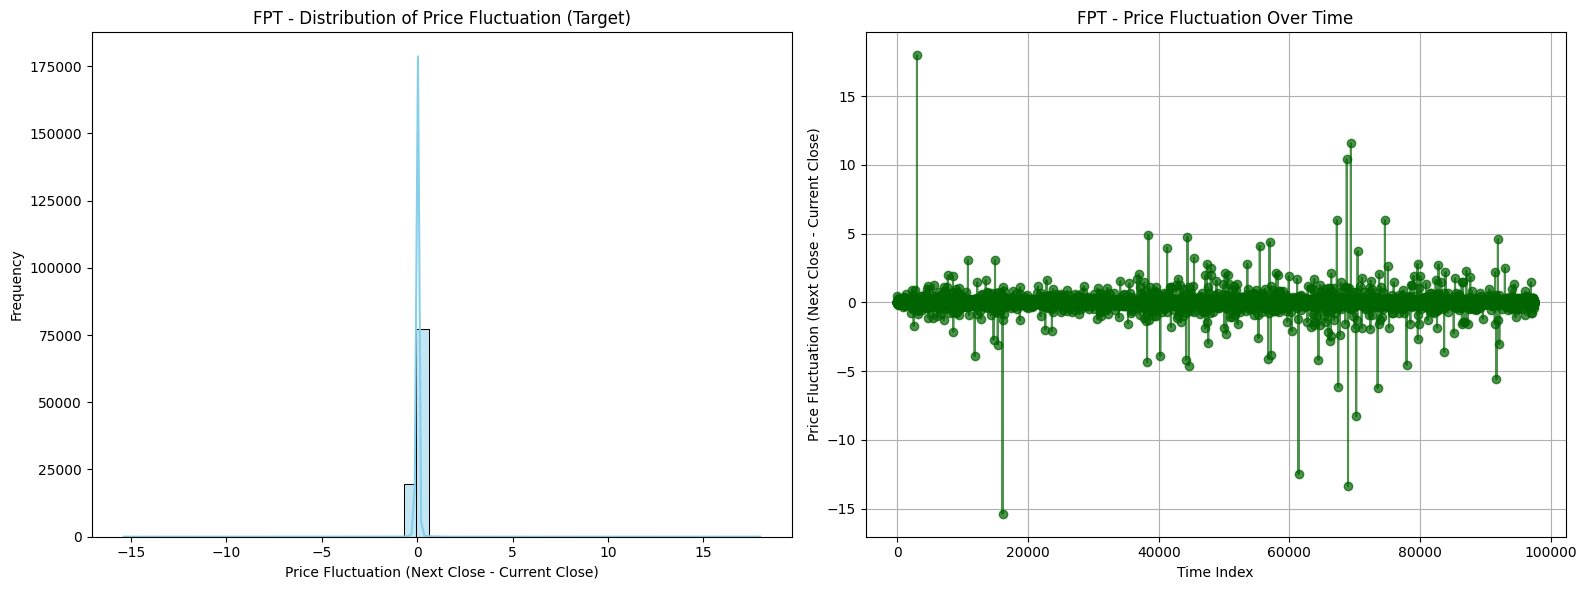

Plotting for MSN stock:


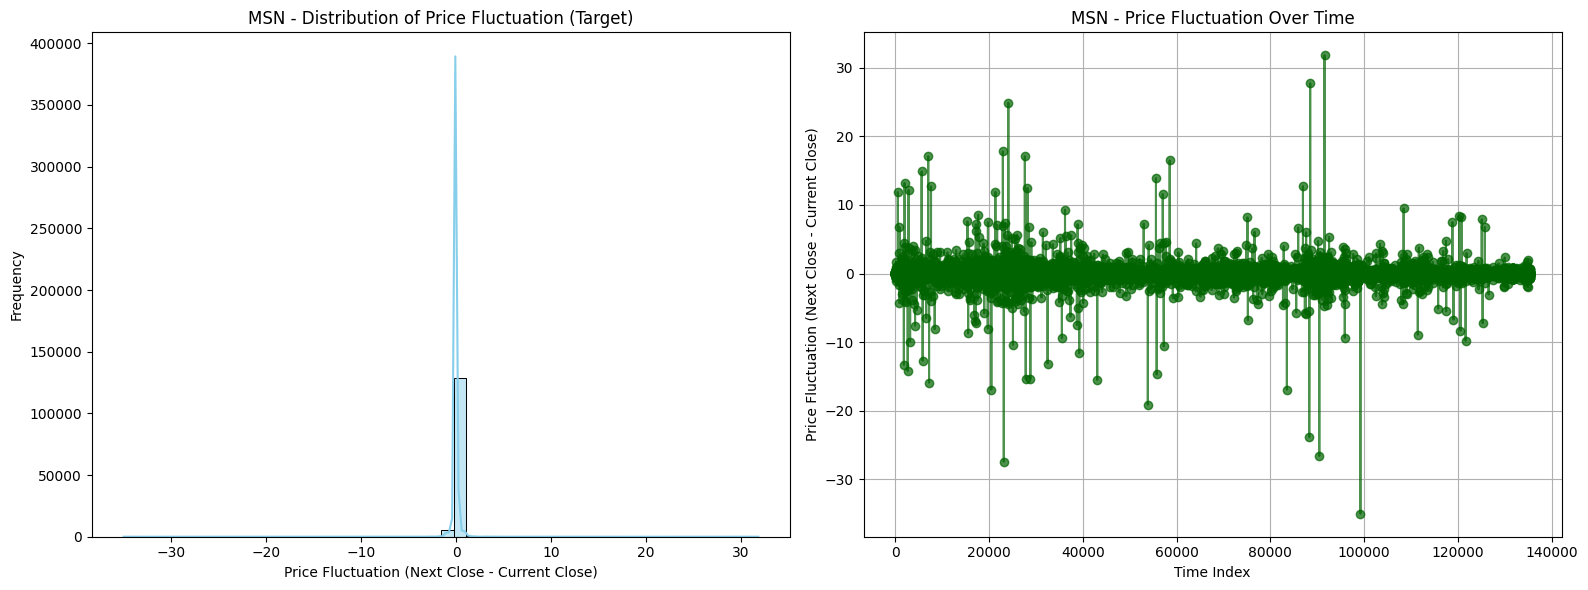

Plotting for PNJ stock:


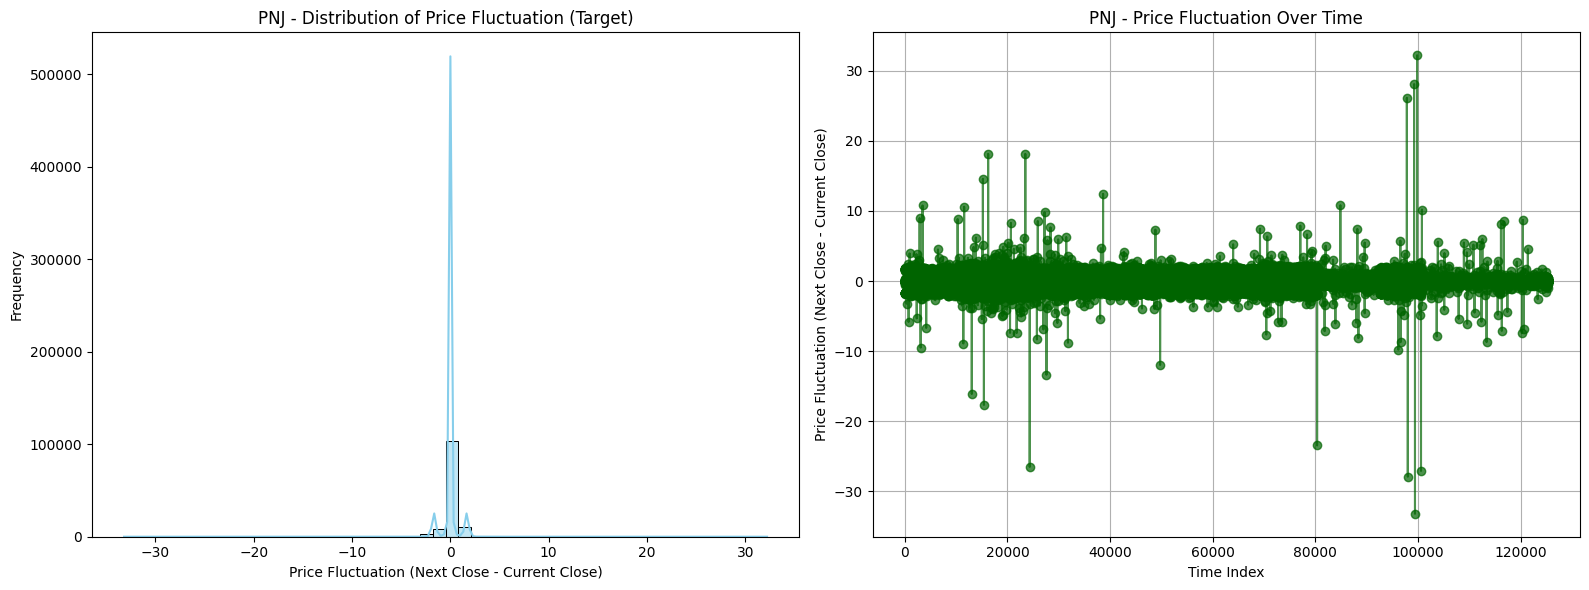

Plotting for VIC stock:


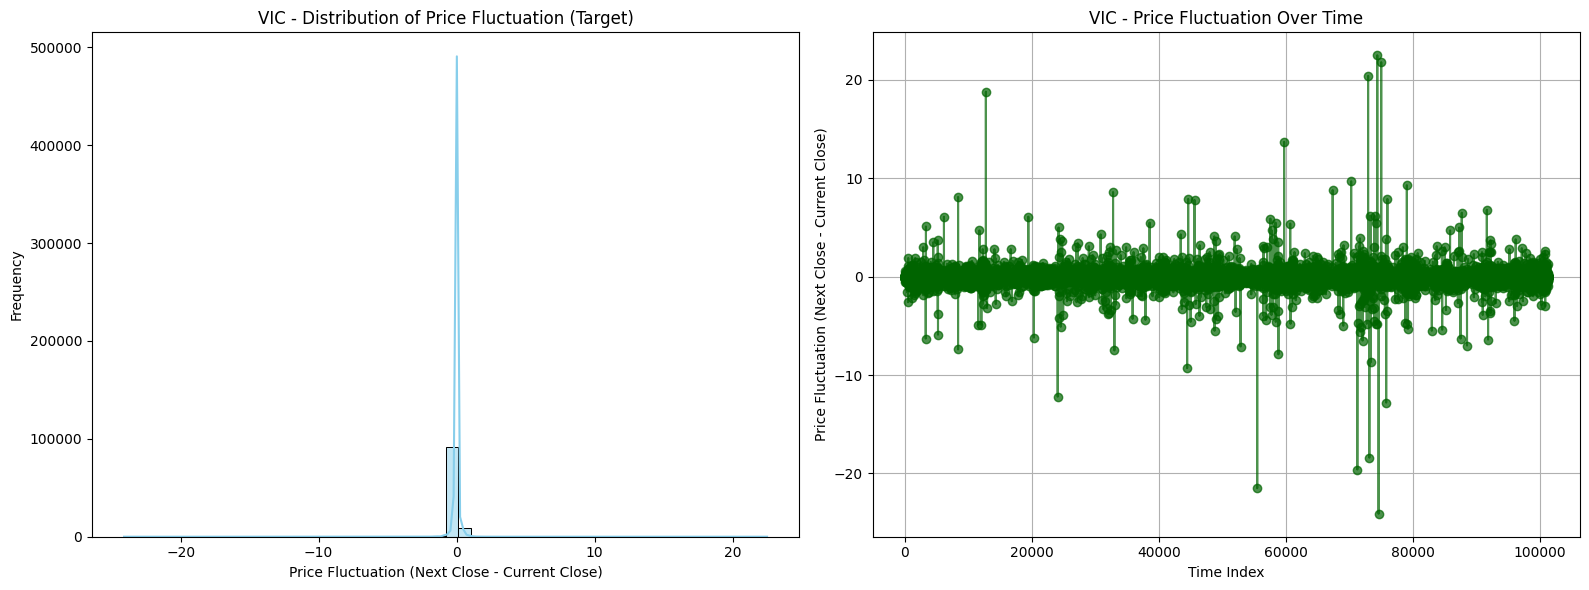

In [172]:
def plot_target_both(df, stock_name):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    # Subplot 1: Histogram
    sns.histplot(df['Target'], bins=50, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title(f"{stock_name} - Distribution of Price Fluctuation (Target)")
    axes[0].set_xlabel("Price Fluctuation (Next Close - Current Close)")
    axes[0].set_ylabel("Frequency")
    # Subplot 2: Time Series
    axes[1].plot(df.index, df['Target'], marker='o', linestyle='-', alpha=0.7, color='darkgreen')
    axes[1].set_title(f"{stock_name} - Price Fluctuation Over Time")
    axes[1].set_xlabel("Time Index")
    axes[1].set_ylabel("Price Fluctuation (Next Close - Current Close)")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
stocks = {"FPT": fpt_data,
          "MSN": msn_data,
          "PNJ": pnj_data,
          "VIC": vic_data}

for stock_name, df in stocks.items():
    print(f"Plotting for {stock_name} stock:")
    plot_target_both(df, stock_name)

## Statitical Test for Feature Selection

#### **Feature Inportance Analysis**

1) FPT:

- F-Regression: Volume, Price Features (Close, Low, High, Open), and Lagged Price Features (Close_lag1, Close_lag2, Close_lag3) are highly significant. Time features (Minute, Hour, Day) show no significant correlation.
- Mutual Information: Price features (Close) and lagged price features have high MI, while Volume has low MI, indicating weak nonlinear prediction.

2) MSN:

- F-Regression: Price Features and Lagged Price Features are highly significant, with Volume also being significant. Time features are not significant.
- Mutual Information: High MI for Minute_Difference and moderate MI for price features. Volume's MI is very low

3) PNJ:

- F-Regression: Price features and lagged price features are extremely significant. Volume is significant, but time features are not.
- Mutual Information: Very high MI for Close and strong MI for High and Low. Time feature Minute_Difference has high MI

4) VIC:

- F-Regression: All price features and lagged price features are significant, while time features are not.
- Mutual Information: High MI for price features and minimal MI for volume. Minute_Difference shows low MI

5) Overview:

- Current and lagged prices are Key predictors
- Volume: Though significant in F-Regression, it contributes little non-linearly (low MI).
- Time features: Limited impact in most cases, though Minute and Day differences have moderate MI in MSN and VIC.


In [153]:
def compute_feature_selection_stats(X, y):
    # Compute F-statistics and p-values
    f_values, p_values = f_regression(X, y)
    f_reg_results = pd.DataFrame({
        'Feature': X.columns,
        'F-statistic': f_values,
        'p-value': p_values
    }).sort_values(by='p-value')

    # Compute Mutual Information scores
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_results = pd.DataFrame({
        'Feature': X.columns,
        'Mutual Information': mi_scores
    }).sort_values(by='Mutual Information', ascending=False)

    return f_reg_results, mi_results
datasets = {
    'FPT': (fpt_data.copy().drop(columns=['Target']), fpt_data.copy()['Target']),
    'MSN': (msn_data.copy().drop(columns=['Target']), msn_data.copy()['Target']),
    'PNJ': (pnj_data.copy().drop(columns=['Target']), pnj_data.copy()['Target']),
    'VIC': (vic_data.copy().drop(columns=['Target']), vic_data.copy()['Target'])
}
for stock, (X, y) in datasets.items():
    f_reg_res, mi_res = compute_feature_selection_stats(X, y)
    print(f"\n=== {stock} F-regression Results ===")
    print(f_reg_res)
    print(f"\n=== {stock} Mutual Information Results ===")
    print(mi_res)


=== FPT F-regression Results ===
              Feature  F-statistic       p-value
4              Volume    95.766291  1.324203e-22
16  Price_Fluctuation    18.734697  1.503736e-05
3               Close    18.734697  1.503736e-05
15        Volume_MA_5    18.670418  1.555281e-05
2                 Low    17.658963  2.645020e-05
1                High    17.448607  2.954372e-05
0                Open    17.146101  3.464104e-05
14         Close_MA_5    16.683187  4.420602e-05
10         Close_lag2    16.208933  5.676887e-05
8          Close_lag1    16.194900  5.719091e-05
12         Close_lag3    16.178115  5.769984e-05
11        Volume_lag2     2.584782  1.078985e-01
6     Hour_Difference     1.894115  1.687417e-01
9         Volume_lag1     1.706015  1.915064e-01
7   Minute_Difference     1.310611  2.522868e-01
5      Day_Difference     1.301049  2.540245e-01
13        Volume_lag3     0.499623  4.796676e-01

=== FPT Mutual Information Results ===
              Feature  Mutual Information
16

#### **Drop unnecessary columns**

- FPT: Price and its lags are strong predictors; time features are not significant, and volume lag features have very low MI.
- MSN: Price features are significant; time features and volume lag features are less useful.
- PNJ: Price features dominate, and time features are almost non‐informative.
- VIC: Price features are important while time features and volume lags add little value.

This makes sense to drop time-based features because Close_lag 1,2,3 contain information related to time-based

In [154]:
for df in [fpt_data, msn_data, pnj_data, vic_data]:
    df.drop(columns=['Minute_Difference', 'Hour_Difference', 'Day_Difference','Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Volume_MA_5'],
            inplace=True, errors='ignore')

# **Machine Learning models**

In [70]:
def print_metrics(model_name, y_true, y_pred):
    print(f"{model_name} MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{model_name} MSE: {mean_squared_error(y_true, y_pred):.4f}\n")

In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error

## FPT

#### **Data Engineering**

In [75]:
# Define features and target variable
features = ['Open',	'High',	'Low',	'Close',	'Volume', 'Close_lag1', 'Close_lag2', 'Close_lag3', 'Close_MA_5']
fpt_X = fpt_data[features]
fpt_y = fpt_data['Target']

# Train-Test Split
fpt_X_train, fpt_X_test, fpt_y_train, fpt_y_test = train_test_split(fpt_X, fpt_y, test_size=0.2, random_state=42) #, stratify=fpt_y)

# Scaled features (for Linear Regression, Neural Network)
scaler = StandardScaler()
fpt_X_train_scaled = scaler.fit_transform(fpt_X_train)
fpt_X_test_scaled = scaler.transform(fpt_X_test)

#### **Machine Learning models**

In [104]:
#### LINEAR REGRESSION ####
lr = LinearRegression(fit_intercept=True)

#### RIDGE REGRESSION ####
ridge = Ridge(alpha=1.0)

#### XGBOOST ####
xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42
)

#### RANDOM FOREST ####
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

#### NEURAL NETWORK (MLP) using Keras ####
mlp = Sequential([
    Input(shape=(fpt_X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

###### Can reuse these models for other stocks ######

In [77]:
#### LINEAR REGRESSION #### Baseline model
lr.fit(fpt_X_train_scaled, fpt_y_train)
fpt_y_pred_lr = lr.predict(fpt_X_test_scaled)

#### RIDGE REGRESSION ####
ridge.fit(fpt_X_train_scaled, fpt_y_train)
fpt_y_pred_ridge = ridge.predict(fpt_X_test_scaled)

#### XGBOOST ####
xgb.fit(fpt_X_train, fpt_y_train)
fpt_y_pred_xgb = xgb.predict(fpt_X_test)

#### RANDOM FOREST ####
rf.fit(fpt_X_train, fpt_y_train)
fpt_y_pred_rf = rf.predict(fpt_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
mlp.fit(fpt_X_train_scaled, fpt_y_train, epochs=30, batch_size=32, verbose=1)
fpt_y_pred_mlp = mlp.predict(fpt_X_test_scaled).flatten()

Epoch 1/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0241
Epoch 2/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0227
Epoch 3/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0203
Epoch 4/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0245
Epoch 5/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0189
Epoch 6/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0303
Epoch 7/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0220
Epoch 8/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0273
Epoch 9/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0227
Epoch 10/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0183
Epoch 11/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0261
Epoch 12/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0240
Epoch 13/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0251
Epoch 14/30
2435/2435 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0223
Epoch 15/30
2435/2435 ━━━━━━

In [78]:
#### Compare models before tuning ####
print_metrics("FPT Linear Regression", fpt_y_test, fpt_y_pred_lr)
print_metrics("FPT Ridge Regression", fpt_y_test, fpt_y_pred_ridge)
print_metrics("FPT XGBoost", fpt_y_test, fpt_y_pred_xgb)
print_metrics("FPT Random Forest", fpt_y_test, fpt_y_pred_rf)
print_metrics("FPT MLP Neural Network", fpt_y_test, fpt_y_pred_mlp)

FPT Linear Regression MAE: 0.0444
FPT Linear Regression MSE: 0.0411

FPT Ridge Regression MAE: 0.0435
FPT Ridge Regression MSE: 0.0411

FPT XGBoost MAE: 0.0422
FPT XGBoost MSE: 0.0413

FPT Random Forest MAE: 0.0430
FPT Random Forest MSE: 0.0415

FPT MLP Neural Network MAE: 0.0420
FPT MLP Neural Network MSE: 0.0412



#### **Tuning** **models**

In [96]:
#### RIDGE REGRESSION #### GridSearchCV
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}
ridge = Ridge()
grid_ridge = GridSearchCV(estimator=ridge,
                          param_grid=param_grid_ridge,
                          cv=3,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

#### XGBOOST #### RandomizedSearchCV
param_rand_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 150, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Use xgboost.XGBRegressor directly instead of xgb.XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

rand_xgb = RandomizedSearchCV(estimator=xgb_reg,
                              param_distributions=param_rand_xgb,
                              cv=3,
                              scoring='neg_mean_squared_error',
                              n_iter=10,
                              n_jobs=-1,
                              random_state=42)

#### RANDOM FOREST #### RandomizedSearchCV
param_rand_rf = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
rf_reg = RandomForestRegressor(random_state=42)
rand_rf = RandomizedSearchCV(estimator=rf_reg,
                             param_distributions=param_rand_rf,
                             cv=2,
                             scoring='neg_mean_squared_error',
                             n_iter=5,
                             n_jobs=-1,
                             random_state=42)

#### NEURAL NETWORK (MLP) using Keras #### Manual Tuning
def build_and_train_mlp(X_train, y_train, X_val, y_val, units1, units2, lr, epochs=30, batch_size=32):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(units=units1, activation='relu'),
        Dense(units=units2, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return model, val_loss
def manual_mlp_tuning(X_train_scaled, y_train, X_test_scaled, y_test,
                        epochs=30, batch_size=32, validation_split=0.2, patience=5):
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train_scaled, y_train, test_size=validation_split, random_state=42
    )
    best_loss = np.inf
    best_params = None
    best_model = None

    param_grid = {
        'units1': [32, 64],
        'units2': [16, 32],
        'lr': [0.001, 0.0005]
    }
    for units1, units2, lr in itertools.product(param_grid['units1'],
                                                  param_grid['units2'],
                                                  param_grid['lr']):
        print(f"Training MLP with units1={units1}, units2={units2}, lr={lr}")
        model, val_loss = build_and_train_mlp(X_train_sub, y_train_sub, X_val, y_val,
                                              units1, units2, lr, epochs, batch_size)
        print(f"Validation loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = {'units1': units1, 'units2': units2, 'lr': lr}
            best_model = model

    print("Best hyperparameters:", best_params)
    print("Best validation loss:", best_loss)

    predictions = best_model.predict(X_test_scaled).flatten()
    return best_model, best_params, best_loss, predictions

###### Can reuse this tuning parameters for other stocks ######

In [85]:
#### RIDGE REGRESSION ####
grid_ridge.fit(fpt_X_train_scaled, fpt_y_train)
print("Best Ridge parameters:", grid_ridge.best_params_)
fpt_y_pred_ridge = grid_ridge.best_estimator_.predict(fpt_X_test_scaled)

#### XGBOOST ####
rand_xgb.fit(fpt_X_train, fpt_y_train)
print("Best XGBoost parameters:", rand_xgb.best_params_)
fpt_y_pred_xgb_tuned = rand_xgb.best_estimator_.predict(fpt_X_test)

#### RANDOM FOREST ####
rand_rf.fit(fpt_X_train, fpt_y_train)
print("Best Random Forest parameters:", rand_rf.best_params_)
fpt_y_pred_rf_tuned = rand_rf.best_estimator_.predict(fpt_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
best_model_fpt, best_params_fpt, best_loss_fpt, fpt_y_pred_mlp_tuned = manual_mlp_tuning(
    fpt_X_train_scaled, fpt_y_train, fpt_X_test_scaled, fpt_y_test,
    epochs=30, batch_size=32, validation_split=0.2, patience=5
)

Best Ridge parameters: {'alpha': 0.001}
Best XGBoost parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best Random Forest parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Training MLP with units1=32, units2=16, lr=0.001
Validation loss: 0.0199
Training MLP with units1=32, units2=16, lr=0.0005
Validation loss: 0.0200
Training MLP with units1=32, units2=32, lr=0.001
Validation loss: 0.0199
Training MLP with units1=32, units2=32, lr=0.0005
Validation loss: 0.0199
Training MLP with units1=64, units2=16, lr=0.001
Validation loss: 0.0199
Training MLP with units1=64, units2=16, lr=0.0005
Validation loss: 0.0199
Training MLP with units1=64, units2=32, lr=0.001
Validation loss: 0.0199
Training MLP with units1=64, units2=32, lr=0.0005
Validation loss: 0.0199
Best hyperparameters: {'units1': 32, 'units2': 32, 'lr': 0.001}
Best validation loss: 0.

In [86]:
#### Compare models after tuning ####
print_metrics("FPT Ridge Regression Tuned", fpt_y_test, fpt_y_pred_ridge)
print_metrics("FPT XGBoost Tuned", fpt_y_test, fpt_y_pred_xgb_tuned)
print_metrics("FPT Random Forest Tuned", fpt_y_test, fpt_y_pred_rf_tuned)
print_metrics("FPT MLP Tuned Neural Network", fpt_y_test, fpt_y_pred_mlp_tuned)

FPT Ridge Regression Tuned MAE: 0.0444
FPT Ridge Regression Tuned MSE: 0.0411

FPT XGBoost Tuned MAE: 0.0419
FPT XGBoost Tuned MSE: 0.0413

FPT Random Forest Tuned MAE: 0.0429
FPT Random Forest Tuned MSE: 0.0415

FPT MLP Tuned Neural Network MAE: 0.0423
FPT MLP Tuned Neural Network MSE: 0.0412



## MSN

#### **Data Enginnering**

In [87]:
# Define features and target variable
msn_X = msn_data[features]
msn_y = msn_data['Target']

# Train-Test Split
msn_X_train, msn_X_test, msn_y_train, msn_y_test = train_test_split(msn_X, msn_y, test_size=0.2, random_state=42)

# Scaled features (for Linear Regression, Neural Network)
scaler = StandardScaler()
msn_X_train_scaled = scaler.fit_transform(msn_X_train)
msn_X_test_scaled = scaler.transform(msn_X_test)

#### **Machine Learning models**

In [91]:
#### LINEAR REGRESSION #### Baseline model
lr.fit(msn_X_train_scaled, msn_y_train)
msn_y_pred_lr = lr.predict(msn_X_test_scaled)

#### RIDGE REGRESSION ####
ridge.fit(msn_X_train_scaled, msn_y_train)
msn_y_pred_ridge = ridge.predict(msn_X_test_scaled)

#### XGBOOST ####
xgb.fit(msn_X_train, msn_y_train)
msn_y_pred_xgb = xgb.predict(msn_X_test)

#### RANDOM FOREST ####
rf.fit(msn_X_train, msn_y_train)
msn_y_pred_rf = rf.predict(msn_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
mlp.fit(msn_X_train_scaled, msn_y_train, epochs=15, batch_size=32, verbose=1)
msn_y_pred_mlp = mlp.predict(msn_X_test_scaled).flatten()

Epoch 1/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2180
Epoch 2/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1830
Epoch 3/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1969
Epoch 4/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1975
Epoch 5/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1836
Epoch 6/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1724
Epoch 7/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2130
Epoch 8/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1818
Epoch 9/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1802
Epoch 10/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1785
Epoch 11/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1483
Epoch 12/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1756
Epoch 13/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1986
Epoch 14/15
3384/3384 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2067
Epoch 15/15
3384/3384 ━━

In [92]:
#### Compare models before tuning ####
print_metrics("MSN Linear Regression", msn_y_test, msn_y_pred_lr)
print_metrics("MSN Ridge Regression", msn_y_test, msn_y_pred_ridge)
print_metrics("MSN XGBoost", msn_y_test, msn_y_pred_xgb)
print_metrics("MSN Random Forest", msn_y_test, msn_y_pred_rf)
print_metrics("MSN MLP Neural Network", msn_y_test, msn_y_pred_mlp)

MSN Linear Regression MAE: 0.1184
MSN Linear Regression MSE: 0.1380

MSN Ridge Regression MAE: 0.1168
MSN Ridge Regression MSE: 0.1381

MSN XGBoost MAE: 0.1131
MSN XGBoost MSE: 0.1423

MSN Random Forest MAE: 0.1142
MSN Random Forest MSE: 0.1430

MSN MLP Neural Network MAE: 0.1139
MSN MLP Neural Network MSE: 0.1429



#### **Tuning models**

In [97]:
#### RIDGE REGRESSION ####
grid_ridge.fit(msn_X_train_scaled, msn_y_train)
print("Best Ridge parameters:", grid_ridge.best_params_)
msn_y_pred_ridge = grid_ridge.best_estimator_.predict(msn_X_test_scaled)

#### XGBOOST ####
rand_xgb.fit(msn_X_train, msn_y_train)
print("Best XGBoost parameters:", rand_xgb.best_params_)
msn_y_pred_xgb_tuned = rand_xgb.best_estimator_.predict(msn_X_test)

#### RANDOM FOREST ####
rand_rf.fit(msn_X_train, msn_y_train)
print("Best Random Forest parameters:", rand_rf.best_params_)
msn_y_pred_rf_tuned = rand_rf.best_estimator_.predict(msn_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
best_model_msn, best_params_msn, best_loss_msn, msn_y_pred_mlp_tuned = manual_mlp_tuning(
    msn_X_train_scaled, msn_y_train, msn_X_test_scaled, msn_y_test,
    epochs=30, batch_size=32, validation_split=0.2, patience=5
)

Best Ridge parameters: {'alpha': 0.001}
Best XGBoost parameters: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best Random Forest parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Training MLP with units1=32, units2=16, lr=0.001
Validation loss: 0.1105
Training MLP with units1=32, units2=16, lr=0.0005
Validation loss: 0.1067
Training MLP with units1=32, units2=32, lr=0.001
Validation loss: 0.1106
Training MLP with units1=32, units2=32, lr=0.0005
Validation loss: 0.1076
Training MLP with units1=64, units2=16, lr=0.001
Validation loss: 0.1106
Training MLP with units1=64, units2=16, lr=0.0005
Validation loss: 0.1099
Training MLP with units1=64, units2=32, lr=0.001
Validation loss: 0.1106
Training MLP with units1=64, units2=32, lr=0.0005
Validation loss: 0.1068
Best hyperparameters: {'units1': 32, 'units2': 16, 'lr': 0.0005}
Best validation loss: 0.10

In [98]:
#### Compare models after tuning ####
print_metrics("MSN Ridge Regression Tuned", msn_y_test, msn_y_pred_ridge)
print_metrics("MSN XGBoost Tuned", msn_y_test, msn_y_pred_xgb_tuned)
print_metrics("MSN Random Forest Tuned", msn_y_test, msn_y_pred_rf_tuned)
print_metrics("MSN MLP Tuned Neural Network", msn_y_test, msn_y_pred_mlp_tuned)

MSN Ridge Regression Tuned MAE: 0.1184
MSN Ridge Regression Tuned MSE: 0.1380

MSN XGBoost Tuned MAE: 0.1155
MSN XGBoost Tuned MSE: 0.1414

MSN Random Forest Tuned MAE: 0.1143
MSN Random Forest Tuned MSE: 0.1433

MSN MLP Tuned Neural Network MAE: 0.1217
MSN MLP Tuned Neural Network MSE: 0.1392



## PNJ

#### **Data Engineering**

In [99]:
# Define features and target variable
pnj_X = pnj_data[features]
pnj_y = pnj_data['Target']

# Train-Test Split
pnj_X_train, pnj_X_test, pnj_y_train, pnj_y_test = train_test_split(pnj_X, pnj_y, test_size=0.2, random_state=42)

# Scaled features (for Linear Regression, Neural Network)
scaler = StandardScaler()
pnj_X_train_scaled = scaler.fit_transform(pnj_X_train)
pnj_X_test_scaled = scaler.transform(pnj_X_test)

#### **Machine Learning models**

In [106]:
#### LINEAR REGRESSION #### Baseline model
lr.fit(pnj_X_train_scaled, pnj_y_train)
pnj_y_pred_lr = lr.predict(pnj_X_test_scaled)

#### RIDGE REGRESSION ####
ridge.fit(pnj_X_train_scaled, pnj_y_train)
pnj_y_pred_ridge = ridge.predict(pnj_X_test_scaled)

#### XGBOOST ####
xgb.fit(pnj_X_train, pnj_y_train)
pnj_y_pred_xgb = xgb.predict(pnj_X_test)

#### RANDOM FOREST ####
rf.fit(pnj_X_train, pnj_y_train)
pnj_y_pred_rf = rf.predict(pnj_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
mlp.fit(pnj_X_train_scaled, pnj_y_train, epochs=15, batch_size=32, verbose=1)
pnj_y_pred_mlp = mlp.predict(pnj_X_test_scaled).flatten()

Epoch 1/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4870
Epoch 2/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4256
Epoch 3/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.4111
Epoch 4/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3935
Epoch 5/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.4000
Epoch 6/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4242
Epoch 7/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3985
Epoch 8/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.3810
Epoch 9/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.4297
Epoch 10/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.4006
Epoch 11/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.3911
Epoch 12/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3968
Epoch 13/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.4126
Epoch 14/15
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3688
Epoch 15/15
3133/3133 ━━

In [107]:
#### Compare models before tuning ####
print_metrics("PNJ Linear Regression", pnj_y_test, pnj_y_pred_lr)
print_metrics("PNJ Ridge Regression", pnj_y_test, pnj_y_pred_ridge)
print_metrics("PNJ XGBoost", pnj_y_test, pnj_y_pred_xgb)
print_metrics("PNJ Random Forest", pnj_y_test, pnj_y_pred_rf)
print_metrics("PNJ MLP Neural Network", pnj_y_test, pnj_y_pred_mlp)

PNJ Linear Regression MAE: 0.3470
PNJ Linear Regression MSE: 0.4687

PNJ Ridge Regression MAE: 0.3469
PNJ Ridge Regression MSE: 0.4686

PNJ XGBoost MAE: 0.3437
PNJ XGBoost MSE: 0.5552

PNJ Random Forest MAE: 0.3427
PNJ Random Forest MSE: 0.5026

PNJ MLP Neural Network MAE: 0.3520
PNJ MLP Neural Network MSE: 0.4212



#### **Tuning models**

In [108]:
#### RIDGE REGRESSION ####
grid_ridge.fit(pnj_X_train_scaled, pnj_y_train)
print("Best Ridge parameters:", grid_ridge.best_params_)
pnj_y_pred_ridge = grid_ridge.best_estimator_.predict(pnj_X_test_scaled)

#### XGBOOST ####
rand_xgb.fit(pnj_X_train, pnj_y_train)
print("Best XGBoost parameters:", rand_xgb.best_params_)
pnj_y_pred_xgb_tuned = rand_xgb.best_estimator_.predict(pnj_X_test)

#### RANDOM FOREST ####
rand_rf.fit(pnj_X_train, pnj_y_train)
print("Best Random Forest parameters:", rand_rf.best_params_)
pnj_y_pred_rf_tuned = rand_rf.best_estimator_.predict(pnj_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
best_model_pnj, best_params_pnj, best_loss_pnj, pnj_y_pred_mlp_tuned = manual_mlp_tuning(
    pnj_X_train_scaled, pnj_y_train, pnj_X_test_scaled, pnj_y_test,
    epochs=30, batch_size=32, validation_split=0.2, patience=5
)

Best Ridge parameters: {'alpha': 0.1}
Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best Random Forest parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
Training MLP with units1=32, units2=16, lr=0.001
Validation loss: 0.4526
Training MLP with units1=32, units2=16, lr=0.0005
Validation loss: 0.4478
Training MLP with units1=32, units2=32, lr=0.001
Validation loss: 0.4517
Training MLP with units1=32, units2=32, lr=0.0005
Validation loss: 0.4490
Training MLP with units1=64, units2=16, lr=0.001
Validation loss: 0.4469
Training MLP with units1=64, units2=16, lr=0.0005
Validation loss: 0.4462
Training MLP with units1=64, units2=32, lr=0.001
Validation loss: 0.4499
Training MLP with units1=64, units2=32, lr=0.0005
Validation loss: 0.4475
Best hyperparameters: {'units1': 64, 'units2': 16, 'lr': 0.0005}
Best validation loss: 0

In [109]:
#### Compare models after tuning ####
print_metrics("PNJ Ridge Regression Tuned", pnj_y_test, pnj_y_pred_ridge)
print_metrics("PNJ XGBoost Tuned", pnj_y_test, pnj_y_pred_xgb_tuned)
print_metrics("PNJ Random Forest Tuned", pnj_y_test, pnj_y_pred_rf_tuned)
print_metrics("PNJ MLP Tuned Neural Network", pnj_y_test, pnj_y_pred_mlp_tuned)

PNJ Ridge Regression Tuned MAE: 0.3470
PNJ Ridge Regression Tuned MSE: 0.4687

PNJ XGBoost Tuned MAE: 0.3469
PNJ XGBoost Tuned MSE: 0.4321

PNJ Random Forest Tuned MAE: 0.3604
PNJ Random Forest Tuned MSE: 0.4339

PNJ MLP Tuned Neural Network MAE: 0.3446
PNJ MLP Tuned Neural Network MSE: 0.4152



## VIC

#### **Data Engineering**

In [110]:
# Define features and target variable
vic_X = vic_data[features]
vic_y = vic_data['Target']

# Train-Test Split
vic_X_train, vic_X_test, vic_y_train, vic_y_test = train_test_split(vic_X, vic_y, test_size=0.2, random_state=42)

# Scaled features (for Linear Regression, Neural Network)
scaler = StandardScaler()
vic_X_train_scaled = scaler.fit_transform(vic_X_train)
vic_X_test_scaled = scaler.transform(vic_X_test)

#### **Machine Learning models**

In [111]:
#### LINEAR REGRESSION #### Baseline model
lr.fit(vic_X_train_scaled, vic_y_train)
vic_y_pred_lr = lr.predict(vic_X_test_scaled)

#### RIDGE REGRESSION ####
ridge.fit(vic_X_train_scaled, vic_y_train)
vic_y_pred_ridge = ridge.predict(vic_X_test_scaled)

#### XGBOOST ####
xgb.fit(vic_X_train, vic_y_train)
vic_y_pred_xgb = xgb.predict(vic_X_test)

#### RANDOM FOREST ####
rf.fit(vic_X_train, vic_y_train)
vic_y_pred_rf = rf.predict(vic_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
mlp.fit(vic_X_train_scaled, vic_y_train, epochs=15, batch_size=32, verbose=1)
vic_y_pred_mlp = mlp.predict(vic_X_test_scaled).flatten()

Epoch 1/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0963
Epoch 2/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1251
Epoch 3/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1031
Epoch 4/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1068
Epoch 5/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0870
Epoch 6/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1216
Epoch 7/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1039
Epoch 8/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1159
Epoch 9/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1022
Epoch 10/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1047
Epoch 11/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0895
Epoch 12/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1173
Epoch 13/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1088
Epoch 14/15
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1085
Epoch 15/15
2532/2532 ━━━━━

In [112]:
#### Compare models before tuning ####
print_metrics("VIC Linear Regression", vic_y_test, vic_y_pred_lr)
print_metrics("VIC Ridge Regression", vic_y_test, vic_y_pred_ridge)
print_metrics("VIC XGBoost", vic_y_test, vic_y_pred_xgb)
print_metrics("VIC Random Forest", vic_y_test, vic_y_pred_rf)
print_metrics("VIC MLP Neural Network", vic_y_test, vic_y_pred_mlp)

VIC Linear Regression MAE: 0.1107
VIC Linear Regression MSE: 0.1003

VIC Ridge Regression MAE: 0.1095
VIC Ridge Regression MSE: 0.1004

VIC XGBoost MAE: 0.1065
VIC XGBoost MSE: 0.1037

VIC Random Forest MAE: 0.1068
VIC Random Forest MSE: 0.1039

VIC MLP Neural Network MAE: 0.1156
VIC MLP Neural Network MSE: 0.1019



#### **Tuning models**

In [113]:
#### RIDGE REGRESSION ####
grid_ridge.fit(vic_X_train_scaled, vic_y_train)
print("Best Ridge parameters:", grid_ridge.best_params_)
vic_y_pred_ridge = grid_ridge.best_estimator_.predict(vic_X_test_scaled)

#### XGBOOST ####
rand_xgb.fit(vic_X_train, vic_y_train)
print("Best XGBoost parameters:", rand_xgb.best_params_)
vic_y_pred_xgb_tuned = rand_xgb.best_estimator_.predict(vic_X_test)

#### RANDOM FOREST ####
rand_rf.fit(vic_X_train, vic_y_train)
print("Best Random Forest parameters:", rand_rf.best_params_)
vic_y_pred_rf_tuned = rand_rf.best_estimator_.predict(vic_X_test)

#### NEURAL NETWORK (MLP) using Keras ####
best_model_vic, best_params_vic, best_loss_vic, vic_y_pred_mlp_tuned = manual_mlp_tuning(
    vic_X_train_scaled, vic_y_train, vic_X_test_scaled, vic_y_test,
    epochs=30, batch_size=32, validation_split=0.2, patience=5
)

Best Ridge parameters: {'alpha': 0.001}
Best XGBoost parameters: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best Random Forest parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Training MLP with units1=32, units2=16, lr=0.001
Validation loss: 0.1639
Training MLP with units1=32, units2=16, lr=0.0005
Validation loss: 0.1616
Training MLP with units1=32, units2=32, lr=0.001
Validation loss: 0.1616
Training MLP with units1=32, units2=32, lr=0.0005
Validation loss: 0.1643
Training MLP with units1=64, units2=16, lr=0.001
Validation loss: 0.1619
Training MLP with units1=64, units2=16, lr=0.0005
Validation loss: 0.1633
Training MLP with units1=64, units2=32, lr=0.001
Validation loss: 0.1609
Training MLP with units1=64, units2=32, lr=0.0005
Validation loss: 0.1598
Best hyperparameters: {'units1': 64, 'units2': 32, 'lr': 0.0005}
Best validation loss: 0.15

In [117]:
#### Compare models after tuning ####
print_metrics("VIC Ridge Regression Tuned", vic_y_test, vic_y_pred_ridge)
print_metrics("VIC XGBoost Tuned", vic_y_test, vic_y_pred_xgb_tuned)
print_metrics("VIC Random Forest Tuned", vic_y_test, vic_y_pred_rf_tuned)
print_metrics("VIC MLP Tuned Neural Network", vic_y_test, vic_y_pred_mlp_tuned)

VIC Ridge Regression Tuned MAE: 0.1107
VIC Ridge Regression Tuned MSE: 0.1003

VIC XGBoost Tuned MAE: 0.1086
VIC XGBoost Tuned MSE: 0.1031

VIC Random Forest Tuned MAE: 0.1069
VIC Random Forest Tuned MSE: 0.1040

VIC MLP Tuned Neural Network MAE: 0.1119
VIC MLP Tuned Neural Network MSE: 0.1007



# **Results and Comparisions of models' performance**

#### **Function for model performance and Metrics used to evaluate models' performance**

- Mean Absolute Error (MAE)
  - absolute differences between the actual and predicted vales
  - lower MAE indicates better model perfomances
- Mean Squared Error (MSE)
  - average of the squared differences between actual and predicted values
  - sensitive to outliers
  - lower MSE indicates better model perfomances
- Root Mean Squared Error (RMSE)
  - sqaure root of MSE

In [125]:
def compare_models_performance(stock_name, y_test, y_preds, model_names):
    results = []

    for model_name, y_pred in zip(model_names, y_preds):
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        results.append({
            'Model': model_name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        })
    results_df = pd.DataFrame(results)
    print("Model Comparison Results for", stock_name)
    print(results_df)
    results_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
    plt.title(f'{stock_name} Model Performance Comparison')  # Dynamic title with stock name
    plt.ylabel('Error')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

model_names = ["Ridge Regression", "XGBoost", "Random Forest", "MLP Neural Network"]

#### **Model performance for FPT**

1) Performance evaluation
- MLP has lowest MAE: At 0.0423 -> averagely, the predictions differ from the actual values by about 0.0423 units
- Ridge achieves lowest MSE & RMSE: 0.0411 and 0.2025, repectively -> On average, squared errors are 0.0411, giving more weight to larger errors, and each prediction is off by 0.2025 units in the original scale of the data

2) Choice of ML models
- When Big Errors Matter: Choose Ridge
- When Average Error Matters: Pick MLP

Model Comparison Results for FPT
                Model       MAE       MSE      RMSE
0    Ridge Regression  0.044438  0.041053  0.202615
1             XGBoost  0.041913  0.041281  0.203177
2       Random Forest  0.042891  0.041512  0.203745
3  MLP Neural Network  0.042263  0.041178  0.202923


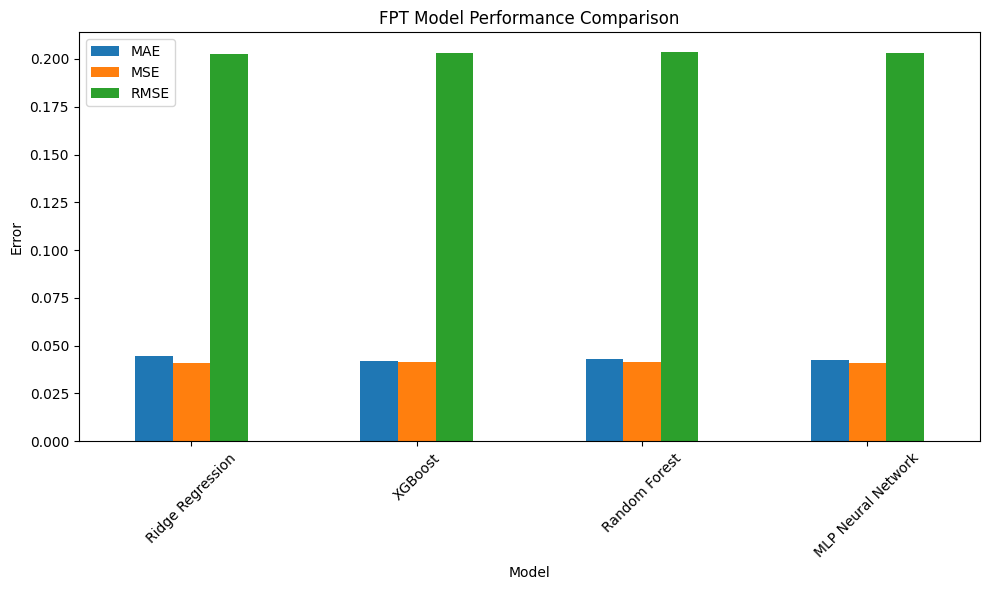

In [127]:
fpt_y_preds = [fpt_y_pred_ridge, fpt_y_pred_xgb_tuned, fpt_y_pred_rf_tuned, fpt_y_pred_mlp_tuned]
compare_models_performance(stock_name="FPT", y_test=fpt_y_test, y_preds=fpt_y_preds, model_names=model_names)

#### **Model performance for MSN**

1) Performance Evaluation
- Random Forest Has Lowest MAE: At 0.1143 -> averagely, the predictions differ from the actual values by about 0.1155 units
- Ridge Achieves the Lowest MSE and RMSE: 0.1380 and 0.371538, respectively -> on average, squared errors are 0.1380, giving more weight to larger errors and each prediction is off by 0.37 units in the original scale of the data

2) Choice of ML Models
- When Big Errors Matter: Choose Ridge
- When Average Error Matters: Pick Random Forest


Model Comparison Results for MSN
                Model       MAE       MSE      RMSE
0    Ridge Regression  0.118394  0.138040  0.371538
1             XGBoost  0.115538  0.141353  0.375970
2       Random Forest  0.114311  0.143287  0.378533
3  MLP Neural Network  0.121699  0.139165  0.373048


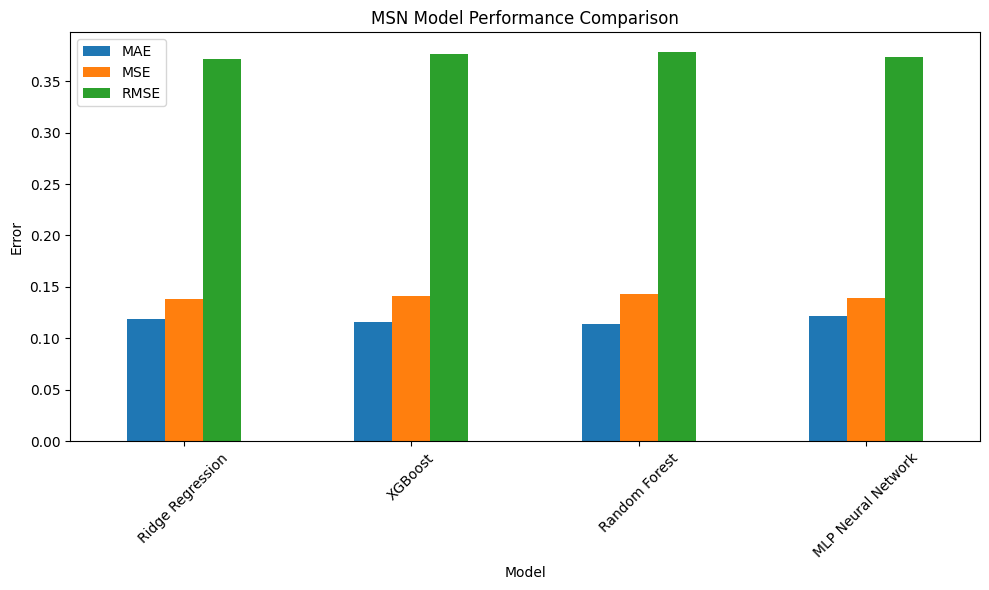

In [128]:
msn_y_preds = [msn_y_pred_ridge, msn_y_pred_xgb_tuned, msn_y_pred_rf_tuned, msn_y_pred_mlp_tuned]
compare_models_performance(stock_name="MSN", y_test=msn_y_test, y_preds=msn_y_preds, model_names=model_names)

#### **Model performance for PNJ**

1) Performance Evaluation

- MLP excels across all metrics:
  - Lowest MAE (0.3446) → On average, the predictions differ from the actual values by about 0.3446 units
  - Lowest MSE (0.4152) → On average, squared errors are 0.4152, giving more weight to larger errors
  - Lowest RMSE (0.6444) → Each prediction is off by about 0.6444 units in the original scale of the data

2) Choice of ML Models: MLP

Model Comparison Results for PNJ
                Model       MAE       MSE      RMSE
0    Ridge Regression  0.347006  0.468686  0.684606
1             XGBoost  0.346945  0.432136  0.657371
2       Random Forest  0.360400  0.433855  0.658676
3  MLP Neural Network  0.344622  0.415195  0.644356


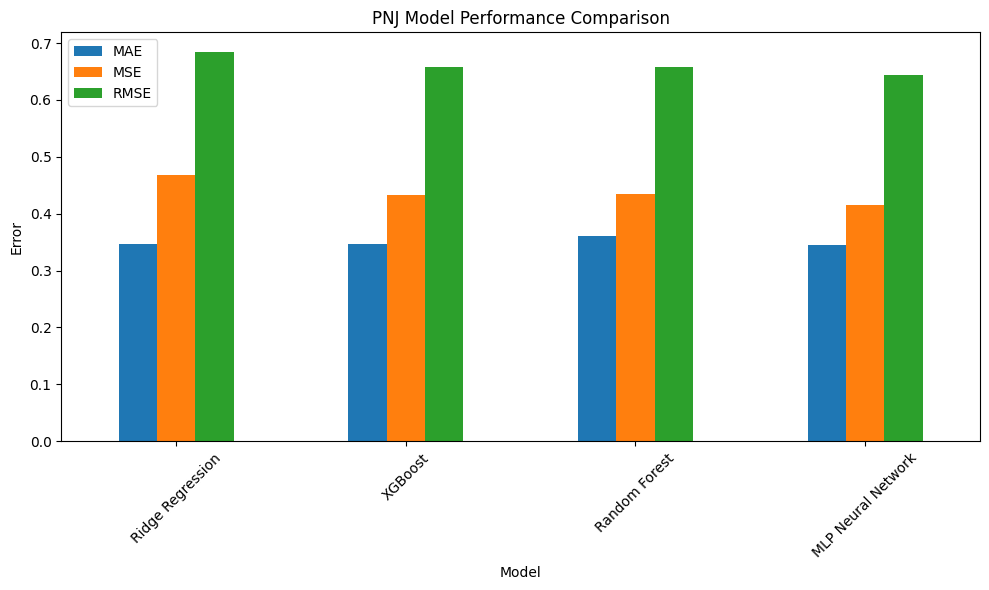

In [129]:
pnj_y_preds = [pnj_y_pred_ridge, pnj_y_pred_xgb_tuned, pnj_y_pred_rf_tuned, pnj_y_pred_mlp_tuned]
compare_models_performance(stock_name="PNJ", y_test=pnj_y_test, y_preds=pnj_y_preds, model_names=model_names)

#### **Model performance for VIC**

1) Performance Evaluation

- Random Forest has the lowest MAE (0.1059) -> On average, the predictions differ from the actual values by about 0.1059 units
- Ridge achieves the lowest MSE and RMSE: 0.1007 and 0.3174, respectively -> On average, squared errors are 0.1007, and each prediction is off by 0.3174 units in the original scale of the data

2) Choice of ML Models
- When Big Errors Matter: Choose Ridge
- When Typical Error Matter: Pick Random Forest

Model Comparison Results for VIC
                Model       MAE       MSE      RMSE
0    Ridge Regression  0.110702  0.100309  0.316716
1             XGBoost  0.108572  0.103078  0.321058
2       Random Forest  0.106912  0.104010  0.322507
3  MLP Neural Network  0.111857  0.100736  0.317389


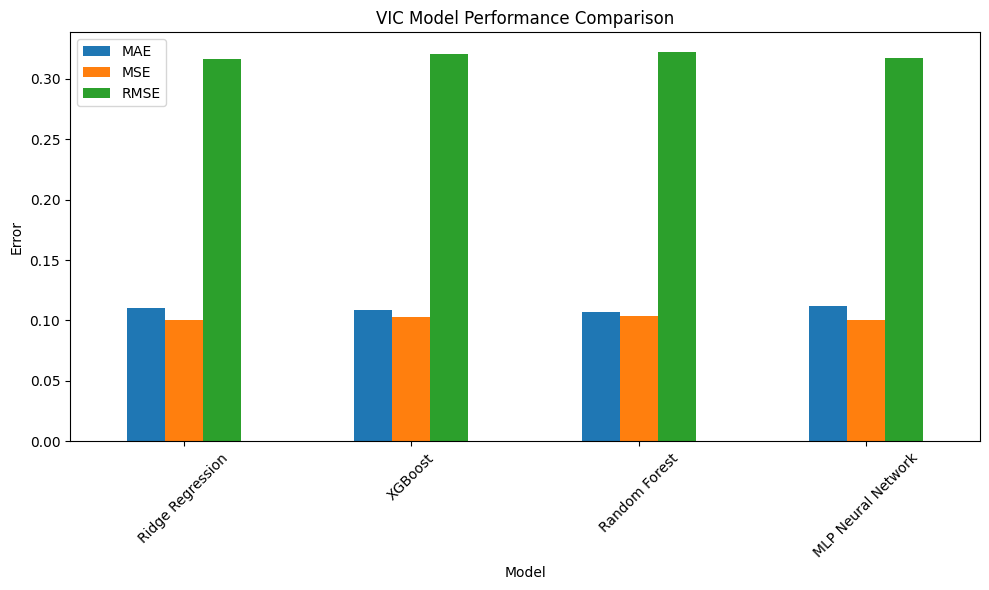

In [130]:
vic_y_preds = [vic_y_pred_ridge, vic_y_pred_xgb_tuned, vic_y_pred_rf_tuned, vic_y_pred_mlp_tuned]
compare_models_performance(stock_name="VIC", y_test=vic_y_test, y_preds=vic_y_preds, model_names=model_names)